1. Importación de librerías
Se importan librerías estándar de Python para manejo de datos (numpy, pandas, polars), visualización (matplotlib, seaborn), procesamiento paralelo (joblib, more_itertools), y machine learning (sklearn). Esto prepara el entorno para análisis, ingeniería de features y modelado.

In [1]:
import numpy as np
import pandas as pd
import gc
import os
import matplotlib.pyplot as plt
import polars as pl
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed
from more_itertools import chunked
from functools import reduce
from typing import List
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from joblib import Parallel, delayed
# --- Standard Library ---
import os
import json
import gc
from functools import reduce
from typing import List

# --- Data Handling ---
import numpy as np
import pandas as pd
import polars as pl
import joblib

# --- Visualization ---
import matplotlib.pyplot as plt

# --- Machine Learning ---
import optuna
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- Parallel Processing ---
from joblib import Parallel, delayed
from more_itertools import chunked

# --- PyTorch (if needed) ---
#import torch.nn as nn

import gc
import optuna
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import holidays
from calendar import monthrange

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Se descarga y carga el dataset principal desde Google Drive, almacenándolo en el DataFrame df_agrupado.

In [ ]:
url = "https://drive.google.com/uc?export=download&id=1jX8gtd7hpLwSrjwkasjG3TZJ3TGIvNzF"
df_agrupado = pd.read_csv(url)

🧠 Generación de características estadísticas sobre series temporales
En esta sección se definen funciones que generan un conjunto enriquecido de features estadísticas y temporales a partir de la evolución histórica de ventas (TN) por producto. Estas características permiten capturar patrones, tendencias, estacionalidades y comportamientos atípicos en la serie temporal, mejorando el poder predictivo de los modelos.

⚙️ add_global_features(group)
Esta función toma como entrada un subconjunto de datos correspondiente a un producto (o grupo) ordenado por periodo (PERIODO), y genera variables globales útiles para el análisis temporal:

- FECHA, MES: extracción de componentes temporales a partir del periodo.
- IS_FEBRERO: indicador binario para meses de febrero.
- ESTOY_PREDICIENDO_FEBRERO: flag para detectar si el periodo actual es diciembre (clave al predecir febrero en t+2).
- CAIDA_ABRUPTA: identifica caídas fuertes de un periodo a otro usando el umbral CAIDA_UMBRAL.
- PROM_ULT_3_FEBREROS: promedio de los últimos 3 valores de febrero previos al periodo actual.
- DIF_TN_VS_FEBREROS_ULT_3: diferencia entre el valor actual y dicho promedio.
- TN_MAX_HISTORICO: valor máximo de TN observado hasta el momento.
- TN_DIST_A_MAX_HIST y TN_RATIO_VS_MAX_HIST: diferencia y proporción del valor actual respecto al máximo histórico.
- Estas features globales permiten capturar efectos estacionales y de referencia en relación a eventos pasados del mismo mes.

Estas features globales permiten capturar efectos estacionales y de referencia en relación a eventos pasados del mismo mes.

🔁 calcular_pendientes_grupo(group, periodos_list)
Esta función extiende add_global_features y calcula una gran cantidad de estadísticas móviles (rolling features) sobre ventanas temporales de tamaños especificados en periodos_list (por ejemplo, 3, 6, 12 meses).

Para cada ventana cant, se calculan:

📊 Estadísticas básicas:
TN_MEAN_xx, TN_MEDIAN_xx, TN_MIN_xx, TN_MAX_xx, TN_STD_xx, TN_SUM_xx, TN_IQR_xx, TN_GROWTH_xx, etc.

📈 Tendencia y dispersión:
- PENDIENTE_TENDENCIA_xx: pendiente de una regresión lineal sobre la ventana.
- TN_SKEW_xx, TN_KURT_xx: asimetría y curtosis.

📌 Indicadores útiles:
- TN_COUNT_POS_xx: cantidad de valores positivos.
- TN_PCT_ZERO_xx: proporción de ceros.
- TN_LAST_xx, TN_LAST_DIFF_xx: último valor y su variación respecto al anterior.
- TN_LAST_PCT_SUM_xx: cuánto representa el último valor del total. 
- TN_ZEROS_END_xx: cuántos ceros consecutivos hay al final de la ventana.
- TN_PCT10_xx, TN_PCT90_xx, TN_PCT_WIDTH_xx: percentiles y amplitud interpercentil.

🔄 Comparaciones del valor actual (TN) con estadísticas móviles:
- TN_MINUS_MEAN_xx, TN_MINUS_MEDIAN_xx, TN_MINUS_EWMA_xx: diferencia respecto a media, mediana y suavizado exponencial.
- TN_OVER_MEAN_xx, TN_OVER_MEDIAN_xx, TN_OVER_EWMA_xx: razón del valor actual sobre estas estadísticas.

🧭 Dinámica temporal:
- TN_CHANGE_PREV_WINDOW_xx: cambio entre la media de la ventana actual y la anterior.
- TN_LAST_VS_MEDIAN_xx: diferencia entre el último valor y la mediana de la ventana.

In [ ]:
# --- Configuración de feriados para Argentina ---
feriados_ar = holidays.AR()

# --- Función auxiliar para PERIODO + 2 ---
def extraer_info_calendario(periodo):
    try:
        anio = int(str(periodo)[:4])
        mes = int(str(periodo)[4:])
        mes_pred = mes + 2
        anio_pred = anio
        if mes_pred > 12:
            mes_pred -= 12
            anio_pred += 1
        
        dias_mes = monthrange(anio_pred, mes_pred)[1]
        fechas_mes = pd.date_range(start=f"{anio_pred}-{mes_pred:02d}-01", periods=dias_mes)

        dias_habiles = fechas_mes[fechas_mes.weekday < 5]
        feriados = [f for f in fechas_mes if f in feriados_ar]
        dias_laborables = [d for d in dias_habiles if d not in feriados]

        return pd.Series({
            "DIAS_MES_PRED": dias_mes,
            "DIAS_HABILES_PRED": len(dias_habiles),
            "FERIADOS_PRED": len(feriados),
            "DIAS_LABORABLES_PRED": len(dias_laborables),
        })
    except:
        return pd.Series({
            "DIAS_MES_PRED": np.nan,
            "DIAS_HABILES_PRED": np.nan,
            "FERIADOS_PRED": np.nan,
            "DIAS_LABORABLES_PRED": np.nan,
        })

# --- Aplicar al DataFrame ---
df_agrupado = df_agrupado.copy()
df_agrupado = df_agrupado.join(df_agrupado['PERIODO'].apply(extraer_info_calendario))

# --- Verificación rápida ---
print(df_agrupado[['PERIODO', 'DIAS_MES_PRED', 'DIAS_HABILES_PRED', 'FERIADOS_PRED', 'DIAS_LABORABLES_PRED']].head())


In [ ]:
ROLL_BASE = 12
CAIDA_UMBRAL = -100

def add_global_features(group):
    group = group.sort_values('PERIODO').copy()
    group['FECHA'] = pd.to_datetime(group['PERIODO'].astype(str), format='%Y%m')
    group['MES'] = group['FECHA'].dt.month
    group['IS_FEBRERO'] = (group['MES'] == 2).astype(int)
    group['ESTOY_PREDICIENDO_FEBRERO'] = (group['MES'] == 12).astype(int)

    group['CAIDA_ABRUPTA'] = (group['TN'].diff(1) < CAIDA_UMBRAL).astype(int)
    
    # Tomar solo los febreros históricos
    febreros = group[group['MES'] == 2][['PERIODO', 'TN']].sort_values('PERIODO').reset_index(drop=True)
    # Calcular el rolling promedio (sin el actual, siempre pasado)
    febreros['PROM_ULT_3_FEBREROS'] = febreros['TN'].shift(1).rolling(window=3, min_periods=1).mean()
    
    # Hacer merge con el original: para cada PERIODO, ¿cuál fue el último promedio disponible?
    # Vamos a usar merge_asof para asignar el promedio más reciente antes o igual al periodo actual
    group = group.sort_values('PERIODO').reset_index(drop=True)
    group = pd.merge_asof(
        group, 
        febreros[['PERIODO', 'PROM_ULT_3_FEBREROS']],
        by=None, left_on='PERIODO', right_on='PERIODO', 
        direction='backward', 
        allow_exact_matches=False
    )
    # Si no hay historial, pone cero (puede cambiar a np.nan si preferís)
    group['PROM_ULT_3_FEBREROS'] = group['PROM_ULT_3_FEBREROS'].fillna(0)
    group['DIF_TN_VS_FEBREROS_ULT_3'] = group['TN'] - group['PROM_ULT_3_FEBREROS']



    # Max histórico HASTA el momento (expanding + shift)
    group['TN_MAX_HISTORICO'] = group['TN'].shift(1).expanding().max().fillna(0)
    group['TN_DIST_A_MAX_HIST'] = group['TN_MAX_HISTORICO'] - group['TN']
    group['TN_RATIO_VS_MAX_HIST'] = (group['TN'] / (group['TN_MAX_HISTORICO'] + 1e-8)).clip(lower=0, upper=5)


    return group


def calcular_pendientes_grupo(group, periodos_list):
    group = add_global_features(group)
    group = group.sort_values(by='PERIODO').copy()
    n = len(group)
    y_values = group['TN'].values
    for cant in periodos_list:
        means = np.zeros(n)
        pendientes = np.zeros(n)
        ewmas = np.zeros(n)
        medians = np.zeros(n)
        minimo = np.zeros(n)
        maximo = np.zeros(n)
        stds = np.zeros(n)
        skews = np.zeros(n)
        kurts = np.zeros(n)
        growths = np.zeros(n)
        iqrs = np.zeros(n)
        sums = np.zeros(n)
        count_pos = np.zeros(n)
        pct_zero = np.zeros(n)
        last = np.zeros(n)
        last_diff = np.zeros(n)

        coef_var = np.zeros(n)
        maxmin_ratio = np.zeros(n)
        rango = np.zeros(n)
        rango_rel = np.zeros(n)
        last_vs_median = np.zeros(n)
        cambio_ventana = np.zeros(n)
        zeros_end = np.zeros(n)
        last_pct_sum = np.zeros(n)
        pct_90 = np.zeros(n)
        pct_10 = np.zeros(n)
        pct_width = np.zeros(n)

        # --- Comparaciones TN vs rolling stats ---
        tn_minus_mean = np.zeros(n)
        tn_minus_median = np.zeros(n)
        tn_minus_ewma = np.zeros(n)
        tn_over_mean = np.zeros(n)
        tn_over_median = np.zeros(n)
        tn_over_ewma = np.zeros(n)

        x = np.arange(cant)
        for i in range(n):
            # Solo procesar si la ventana está completa
            if i >= cant - 1:
                y = y_values[i - (cant - 1): i + 1]
                means[i] = np.mean(y)
                try:
                    pendientes[i] = np.polyfit(x, y, 1)[0]
                except:
                    pendientes[i] = 0
                ewmas[i] = pd.Series(y).ewm(span=cant, adjust=False).mean().iloc[-1]
                medians[i] = np.median(y)
                minimo[i] = np.min(y)
                maximo[i] = np.max(y)
                std_y = np.std(y)
                mean_y = means[i]
                stds[i] = std_y
                skews[i] = skew(y) if std_y > 0 else 0
                kurts[i] = kurtosis(y) if std_y > 0 else 0
                growths[i] = (y[-1] - y[0]) / (y[0] + 1e-8) if y[0] != 0 else 0
                iqrs[i] = np.percentile(y, 75) - np.percentile(y, 25)
                sums[i] = np.sum(y)
                count_pos[i] = np.sum(y > 0)
                pct_zero[i] = np.mean(y == 0)
                last[i] = y[-1]
                last_diff[i] = y[-1] - y[-2] if cant > 1 else 0

                coef_var[i] = std_y / (mean_y + 1e-8) if mean_y != 0 else 0
                maxmin_ratio[i] = maximo[i] / (minimo[i] + 1e-8) if minimo[i] != 0 else 0
                rango[i] = maximo[i] - minimo[i]
                rango_rel[i] = rango[i] / (minimo[i] + 1e-8) if minimo[i] != 0 else 0
                last_vs_median[i] = y[-1] - np.median(y)
                # Cambio de ventana anterior a actual
                if i >= 2 * cant - 1:
                    y_prev = y_values[i - (2 * cant - 1):i - cant + 1]
                    mean_prev = np.mean(y_prev)
                    cambio_ventana[i] = (mean_y - mean_prev) / (mean_prev + 1e-8) if mean_prev != 0 else 0
                zeros_end[i] = np.argmax(y[::-1] != 0)
                last_pct_sum[i] = y[-1] / (np.sum(y) + 1e-8) if np.sum(y) != 0 else 0
                pct_90[i] = np.percentile(y, 90)
                pct_10[i] = np.percentile(y, 10)
                pct_width[i] = pct_90[i] - pct_10[i]

                # Comparaciones TN vs rolling stats
                tn_actual = y_values[i]
                tn_minus_mean[i] = tn_actual - means[i]
                tn_minus_median[i] = tn_actual - medians[i]
                tn_minus_ewma[i] = tn_actual - ewmas[i]
                tn_over_mean[i] = tn_actual / (means[i] + 1e-8) if means[i] != 0 else 0
                tn_over_median[i] = tn_actual / (medians[i] + 1e-8) if medians[i] != 0 else 0
                tn_over_ewma[i] = tn_actual / (ewmas[i] + 1e-8) if ewmas[i] != 0 else 0
            # Si la ventana no está completa, todo queda en cero (ya inicializado)

        group[f'TN_MEAN_{str(cant).zfill(2)}'] = means
        group[f'PENDIENTE_TENDENCIA_{cant}'] = pendientes
        group[f'TN_EWMA_{str(cant).zfill(2)}'] = ewmas
        group[f'TN_MEDIAN_{str(cant).zfill(2)}'] = medians
        group[f'TN_MIN_{str(cant).zfill(2)}'] = minimo
        group[f'TN_MAX_{str(cant).zfill(2)}'] = maximo
        group[f'TN_STD_{str(cant).zfill(2)}'] = stds
        group[f'TN_SKEW_{str(cant).zfill(2)}'] = skews
        group[f'TN_KURT_{str(cant).zfill(2)}'] = kurts
        group[f'TN_GROWTH_{str(cant).zfill(2)}'] = growths
        group[f'TN_IQR_{str(cant).zfill(2)}'] = iqrs
        group[f'TN_SUM_{str(cant).zfill(2)}'] = sums
        group[f'TN_COUNT_POS_{str(cant).zfill(2)}'] = count_pos
        group[f'TN_PCT_ZERO_{str(cant).zfill(2)}'] = pct_zero
        group[f'TN_LAST_{str(cant).zfill(2)}'] = last
        group[f'TN_LAST_DIFF_{str(cant).zfill(2)}'] = last_diff

        group[f'TN_COEF_VAR_{cant}'] = coef_var
        group[f'TN_MAXMIN_RATIO_{cant}'] = maxmin_ratio
        group[f'TN_RANGO_{cant}'] = rango
        group[f'TN_RANGO_REL_{cant}'] = rango_rel
        group[f'TN_LAST_VS_MEDIAN_{cant}'] = last_vs_median
        group[f'TN_CHANGE_PREV_WINDOW_{cant}'] = cambio_ventana
        group[f'TN_ZEROS_END_{cant}'] = zeros_end
        group[f'TN_LAST_PCT_SUM_{cant}'] = last_pct_sum
        group[f'TN_PCT90_{cant}'] = pct_90
        group[f'TN_PCT10_{cant}'] = pct_10
        group[f'TN_PCT_WIDTH_{cant}'] = pct_width

        # Comparaciones TN vs rolling stats
        group[f'TN_MINUS_MEAN_{str(cant).zfill(2)}'] = tn_minus_mean
        group[f'TN_MINUS_MEDIAN_{str(cant).zfill(2)}'] = tn_minus_median
        group[f'TN_MINUS_EWMA_{str(cant).zfill(2)}'] = tn_minus_ewma
        group[f'TN_OVER_MEAN_{str(cant).zfill(2)}'] = tn_over_mean
        group[f'TN_OVER_MEDIAN_{str(cant).zfill(2)}'] = tn_over_median
        group[f'TN_OVER_EWMA_{str(cant).zfill(2)}'] = tn_over_ewma

    return group

⚙️ Cálculo paralelo de estadísticas temporales por producto
Se define una función llamada calcular_pendientes_parallel que aplica la ingeniería de variables temporales sobre el conjunto completo de productos de forma paralela, lo que permite acelerar considerablemente el procesamiento.

🧩 Descripción del procedimiento
Agrupamiento por producto
Se separan los datos por PRODUCT_ID, de modo que cada grupo contenga la serie temporal correspondiente a un único producto.

Procesamiento en paralelo
Usando joblib.Parallel, se aplica la función calcular_pendientes_grupo (que genera estadísticas móviles e indicadores por ventana) a cada grupo de productos en paralelo, distribuyendo el trabajo en n_jobs procesos.

Unificación de resultados
Se concatenan todos los resultados en un único DataFrame (df_final), garantizando que no queden valores infinitos ni nulos (NaN), reemplazándolos por cero para mantener consistencia.

⚙️ Parámetros principales
df: DataFrame original agrupado por producto.

periodos_list: lista de tamaños de ventanas móviles sobre las cuales se calculan las estadísticas.

n_jobs: número de procesos paralelos a utilizar (ajustable según los núcleos disponibles).

In [ ]:
def calcular_pendientes_parallel(df, periodos_list=[3, 6, 9, 12, 18], n_jobs=28):
    grupos = [group for _, group in df.groupby('PRODUCT_ID')]
    resultados = Parallel(n_jobs=n_jobs, backend='loky', verbose=10)(
        delayed(calcular_pendientes_grupo)(group, periodos_list) for group in grupos
    )
    df_final = pd.concat(resultados, ignore_index=True)
    df_final.replace([np.inf, -np.inf], 0, inplace=True)
    df_final.fillna(0, inplace=True)
    return df_final

df_agrupado = calcular_pendientes_parallel(df_agrupado, periodos_list=[3, 6, 9, 12, 18], n_jobs=28)

### 🔁 Generación de variables lag y delta

Se generan variables `lag` y `delta` sobre la variable objetivo `TN`, calculadas por grupo de producto (`PRODUCT_ID`) y ordenadas de forma descendente por el campo `ORDINAL`.

Para cada ventana temporal definida en `lags = [3, 6, 9, 12, 18]`, se calculan:

- `TN_LAG_xx`: valor de `TN` con un desplazamiento hacia el futuro de `xx` periodos (dado que el orden es descendente).
- `TN_DELTA_xx`: diferencia entre el valor actual de `TN` y su respectivo `lag`.

Estas variables permiten capturar el comportamiento reciente de la serie y medir variaciones en diferentes horizontes temporales.

In [ ]:
lags = [3, 6, 9, 12, 18]
group_cols = ['PRODUCT_ID']

# Ordenar de forma cronológica (ORDINAL ascendente)
df_agrupado = df_agrupado.sort_values(group_cols + ['ORDINAL'], ascending=[True, True])

for lag in lags:
    lag_col = f'TN_LAG_{lag:02d}'
    delta_col = f'TN_DELTA_{lag:02d}'
    
    # Lag tradicional: hacia el pasado (ej. en t=10, el lag 3 es t=7)
    df_agrupado[lag_col] = (
        df_agrupado.groupby(group_cols)['TN']
        .shift(lag)  # ✅ correcto: va al pasado
        .fillna(0)
    )
    
    # Delta entre el valor actual y el de hace n períodos
    df_agrupado[delta_col] = df_agrupado['TN'] - df_agrupado[lag_col]


### 📈 Cálculo de métricas adicionales sobre ventanas móviles

Sobre ventanas móviles de 3, 6, 9, 12 y 18 periodos, se generaron nuevas variables por producto (`PRODUCT_ID`) a partir de la serie `TN`, con el objetivo de capturar distintos aspectos del comportamiento reciente de la serie.

Para cada ventana se calcularon:

- `TN_GROWTH_xx`: crecimiento porcentual respecto al valor observado `xx` periodos atrás (`lag`).
- `TN_COUNT_ZERO_xx`: cantidad de ceros en la ventana.
- `TN_SIGN_CHANGES_xx`: cantidad de cambios de signo (positivo ↔ negativo).
- `TN_COEF_VAR_xx`: coeficiente de variación, como relación entre el desvío estándar y la media.
- `TN_OUTLIER_PROP_xx`: proporción de valores considerados outliers (más de 2 desvíos estándar respecto a la media).
- `TN_PCT_POS_xx`: proporción de ventas mayores a cero.

Estas variables permiten describir la estabilidad, dispersión, presencia de outliers y comportamiento general reciente de la variable objetivo.


In [ ]:
# --- Parámetros ---
windows = [3, 6, 9, 12, 18]
group_cols = ['PRODUCT_ID']  # Podés agregar más si agrupás por otras claves
target_col = 'TN'

# --- Asegurar orden temporal correcto para rolling ---
df_agrupado = df_agrupado.sort_values(group_cols + ['ORDINAL'], ascending=True)

# --- Función auxiliar para proporción de outliers (> 2 * std) ---
def outlier_prop(x):
    m = np.nanmean(x)
    s = np.nanstd(x)
    if s == 0:
        return 0
    return np.mean(np.abs(x - m) > 2 * s)

# --- Loop por cada ventana temporal ---
for w in windows:
    # 1. CRECIMIENTO PERCENTUAL (respecto al lag ya calculado)
    lag_col = f'{target_col}_LAG_{w:02d}'
    growth_col = f'{target_col}_GROWTH_{w:02d}'
    if lag_col in df_agrupado.columns:
        df_agrupado[growth_col] = (
            (df_agrupado[target_col] - df_agrupado[lag_col]) /
            (df_agrupado[lag_col].replace(0, np.nan))
        ).fillna(0)

    # 2. CANTIDAD DE CEROS en la ventana
    count_zero_col = f'{target_col}_COUNT_ZERO_{w:02d}'
    df_agrupado[count_zero_col] = (
        df_agrupado
        .groupby(group_cols)[target_col]
        .rolling(window=w, min_periods=1)
        .apply(lambda x: np.sum(x == 0), raw=True)
        .reset_index(level=0, drop=True)
    )

    # 3. CAMBIOS DE SIGNO
    sign_change_col = f'{target_col}_SIGN_CHANGES_{w:02d}'
    df_agrupado[sign_change_col] = (
        df_agrupado
        .groupby(group_cols)[target_col]
        .rolling(window=w, min_periods=2)
        .apply(lambda x: np.sum(np.diff(np.sign(x)) != 0), raw=True)
        .reset_index(level=0, drop=True)
    )

    # 4. MEDIA y DESVÍO ESTÁNDAR (si no existen)
    mean_col = f'{target_col}_MEAN_{w:02d}'
    std_col = f'{target_col}_STD_{w:02d}'
    if mean_col not in df_agrupado.columns:
        df_agrupado[mean_col] = (
            df_agrupado.groupby(group_cols)[target_col]
            .rolling(window=w, min_periods=1)
            .mean()
            .reset_index(level=0, drop=True)
        )
    if std_col not in df_agrupado.columns:
        df_agrupado[std_col] = (
            df_agrupado.groupby(group_cols)[target_col]
            .rolling(window=w, min_periods=1)
            .std()
            .fillna(0)
            .reset_index(level=0, drop=True)
        )

    # 5. COEFICIENTE DE VARIACIÓN
    coef_var_col = f'{target_col}_COEF_VAR_{w:02d}'
    df_agrupado[coef_var_col] = (
        df_agrupado[std_col] / df_agrupado[mean_col].replace(0, np.nan)
    ).fillna(0)

    # 6. PROPORCIÓN DE OUTLIERS
    outlier_col = f'{target_col}_OUTLIER_PROP_{w:02d}'
    df_agrupado[outlier_col] = (
        df_agrupado
        .groupby(group_cols)[target_col]
        .rolling(window=w, min_periods=2)
        .apply(outlier_prop, raw=True)
        .reset_index(level=0, drop=True)
    )

    # 7. PROPORCIÓN DE VALORES POSITIVOS
    pct_pos_col = f'{target_col}_PCT_POS_{w:02d}'
    df_agrupado[pct_pos_col] = (
        df_agrupado
        .groupby(group_cols)[target_col]
        .rolling(window=w, min_periods=1)
        .apply(lambda x: np.mean(x > 0), raw=True)
        .reset_index(level=0, drop=True)
    )

# --- Columnas generadas (opcional para ver resumen) ---
cols_new = []
for w in windows:
    cols_new += [
        f'{target_col}_GROWTH_{w:02d}',
        f'{target_col}_COUNT_ZERO_{w:02d}',
        f'{target_col}_SIGN_CHANGES_{w:02d}',
        f'{target_col}_MEAN_{w:02d}',
        f'{target_col}_STD_{w:02d}',
        f'{target_col}_COEF_VAR_{w:02d}',
        f'{target_col}_OUTLIER_PROP_{w:02d}',
        f'{target_col}_PCT_POS_{w:02d}',
    ]

# Verificación rápida
print("Nuevas columnas generadas:")
print(cols_new)
print(df_agrupado[cols_new].isna().sum())

In [ ]:
# Hacer un EDA de la columna  CLASE en  df_agrupado
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Estadísticas descriptivas ---
print("Estadísticas básicas de CLASE:")
print(df_agrupado['CLASE'].describe())

print("\nPrimeros valores únicos (si son pocos):", df_agrupado['CLASE'].unique()[:10])
print("Cantidad de valores únicos:", df_agrupado['CLASE'].nunique())

print("\nCantidad de nulos:", df_agrupado['CLASE'].isna().sum())

# --- Histograma ---
plt.figure(figsize=(8,4))
sns.histplot(df_agrupado['CLASE'], bins=30, kde=True)
plt.title("Histograma de CLASE")
plt.xlabel("CLASE")
plt.ylabel("Frecuencia")
plt.show()

# --- Boxplot para ver outliers ---
plt.figure(figsize=(8,2))
sns.boxplot(x=df_agrupado['CLASE'])
plt.title("Boxplot de CLASE")
plt.show()

# --- Distribución log-transformada (útil si hay muchos valores chicos y pocos grandes) ---
plt.figure(figsize=(8,4))
sns.histplot(np.log1p(df_agrupado['CLASE']), bins=30, kde=True)
plt.title("Histograma de log(1+CLASE)")
plt.xlabel("log(1+CLASE)")
plt.ylabel("Frecuencia")
plt.show()

# --- Percentiles y cuantiles ---
print("\nPercentiles de CLASE:")
print(df_agrupado['CLASE'].quantile([0, 0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1]))

# --- Outliers extremos (más allá de 3 desviaciones estándar) ---
media = df_agrupado['CLASE'].mean()
std = df_agrupado['CLASE'].std()
outliers = df_agrupado[(df_agrupado['CLASE'] > media + 3*std) | (df_agrupado['CLASE'] < media - 3*std)]
print(f"\nCantidad de outliers (>3 desvíos): {len(outliers)}")


# --- Suma de CLASE por PERIODO y visualización temporal ---
if 'PERIODO' in df_agrupado.columns:
    # Agrupar y sumar CLASE por PERIODO
    df_suma_clase = df_agrupado.groupby('PERIODO', as_index=False)['CLASE'].sum()
    
    # Convertir PERIODO a fecha para mejor visualización
    df_suma_clase['PERIODO_FECHA'] = pd.to_datetime(df_suma_clase['PERIODO'].astype(str), format='%Y%m')

    # Graficar
    plt.figure(figsize=(10, 4))
    sns.lineplot(x='PERIODO_FECHA', y='CLASE', data=df_suma_clase, errorbar=None)
    #sns.lineplot(x='PERIODO_FECHA', y='CLASE', data=df_suma_clase, ci=None)
    plt.title("Suma de CLASE por mes")
    plt.xlabel("PERIODO")
    plt.ylabel("Suma de CLASE")
    plt.tight_layout()
    plt.show()



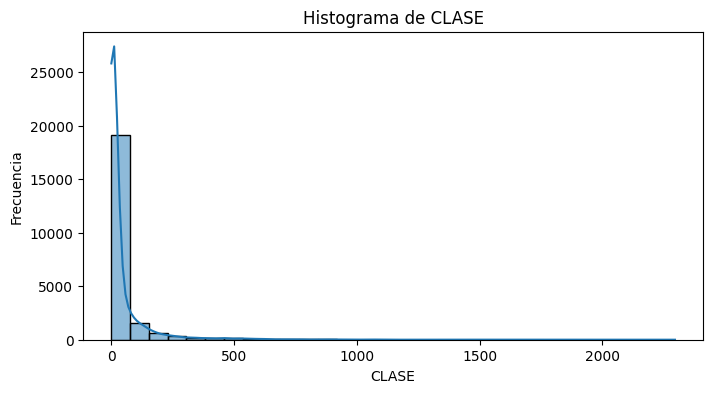

📊 Análisis de distribución: variable CLASE
🔹 Histograma original (CLASE)
El primer gráfico muestra el histograma de la variable CLASE sin transformar. Se observa una alta concentración de valores en el rango bajo, con una gran cantidad de registros cercanos a cero y una cola larga hacia la derecha, que indica la presencia de valores atípicos altos (distribución fuertemente asimétrica positiva).

Este tipo de distribución sesgada es común en variables de conteo o montos que pueden tomar muchos valores pequeños y algunos grandes (como ingresos, ventas, etc.). En este caso:

La mayoría de los valores están por debajo de 100.

Existen valores extremos por encima de 2000, aunque poco frecuentes.

Esta asimetría puede afectar negativamente el rendimiento de modelos sensibles a la escala o la normalidad de los datos (por ejemplo, regresión lineal o redes neuronales sin normalización adecuada).

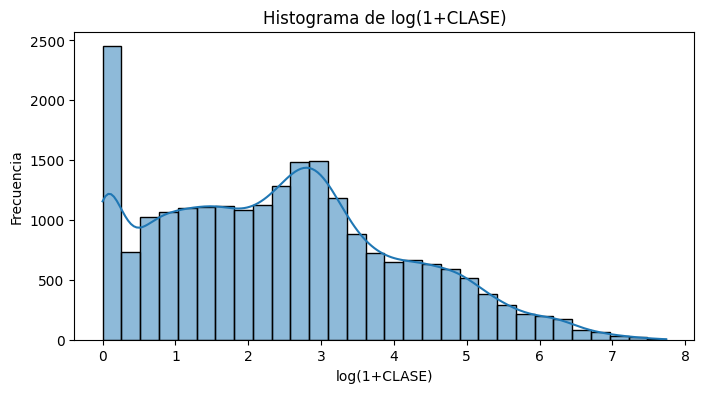

🔹 Histograma transformado (log(1 + CLASE))
El segundo gráfico muestra el histograma de log(1 + CLASE). Se aplica log(1 + x) para manejar los ceros sin generar valores indefinidos, ya que log(0) no está definido.

Con esta transformación:

La distribución se vuelve mucho más simétrica y cercana a una forma aproximadamente normal o al menos continua y más balanceada.

Los valores atípicos son "comprimidos", lo que reduce su efecto desproporcionado sobre los modelos.

La dispersión de los datos mejora, favoreciendo algoritmos que se benefician de distribuciones menos sesgadas (como MLP, k-NN, clustering, etc.).

✅ Justificación de la transformación
Transformar CLASE mediante log(1 + CLASE) es una práctica adecuada cuando:

La variable tiene valores positivos y altamente asimétricos, como en este caso.

Se quiere reducir el impacto de los outliers o valores extremos.

Se busca estabilizar la varianza para mejorar la calidad del modelado.

Se desea facilitar el entrenamiento de modelos lineales o redes neuronales que pueden verse perjudicadas por escalas tan dispares.



In [ ]:
df_agrupado['CLASE_LOG1P'] = np.log1p(df_agrupado['CLASE'])

# Eliminar las columnas CLASE  para evitar confusiones
df_agrupado.drop(columns=['CLASE'], inplace=True, errors='ignore')

In [ ]:
# Eliminar de df_agrupado la columna FECHA
df_agrupado = df_agrupado.drop(columns=['FECHA'], errors='ignore')

In [ ]:
cat_cols = ['ID_CAT1', 'ID_CAT2', 'ID_CAT3', 'ID_BRAND', 'SKU_SIZE','MES_PROBLEMATICO',
            'IS_FEBRERO', 'ESTOY_PREDICIENDO_FEBRERO','CAIDA_ABRUPTA']

for col in cat_cols:
    if col in df_agrupado.columns:
        df_agrupado[col] = df_agrupado[col].astype('category')

In [ ]:
df_agrupado.to_csv('./data/product_interm_LGBM.csv', index=False)

In [2]:
df_agrupado = pd.read_csv('./data/product_interm_LGBM.csv')

In [3]:
# df_full = pd.read_parquet('./data/product_interm_LGBM.parquet', engine='fastparquet')
# Separar conjuntos
df_full = df_agrupado
df_train = df_full[df_full['PERIODO'] <= 201812].copy()
df_val = df_full[df_full['PERIODO'].between(201901, 201909)].copy()
df_test = df_full[(df_full['PERIODO'] == 201910)].copy()
df_target_201912 = df_full[df_full['PERIODO'] == 201912].copy()
gc.collect()

0

In [4]:
def total_forecast_error(y_true, y_pred):
    """
    Calcula el error porcentual total de pronóstico (Total Forecast Error),
    definido como la suma del error absoluto dividido por la suma total del valor real.

    Esta métrica es útil para evaluar el desempeño del modelo en términos relativos
    al volumen total observado, especialmente cuando se quiere penalizar proporcionalmente
    las desviaciones en función del tamaño real.

    Fórmula:
        TFE = sum(|y_true - y_pred|) / sum(y_true)

    Si la suma de y_true es cero, devuelve NaN para evitar división por cero.

    Parámetros:
        y_true (array-like): valores reales
        y_pred (array-like): valores predichos

    Retorna:
        float: error porcentual total
    """
    numerador = np.sum(np.abs(y_true - y_pred))
    denominador = np.sum(y_true)
    if denominador == 0:
        return np.nan
    return numerador / denominador

In [5]:
# --- SETUP ---
# En este caso, es la clase transformada con log1p (log(1 + x)), usada para estabilizar la varianza.
target_col = 'CLASE_LOG1P'
feature_cols = [col for col in df_train.columns if col != target_col]

X_tr = df_train[feature_cols]
y_tr = df_train[target_col]
X_val = df_val[feature_cols]
y_val = df_val[target_col]

## Optimización de Hiperparámetros para LightGBM usando Optuna

### 1. Definición de la Función Objetivo

Se define una función `objective_lgbm(trial)` que toma una muestra de hiperparámetros y entrena un modelo LightGBM para minimizar el error total de forecast (`Total Forecast Error`, TFE). Los hiperparámetros incluyen:

- `learning_rate`, `num_leaves`, `max_depth`, `n_estimators`
- Parámetros de regularización (`reg_alpha`, `reg_lambda`)
- Subsampling (`subsample`, `colsample_bytree`)
- Otros (`min_child_samples`, `min_split_gain`, `random_state`)

Se usa el `mean_absolute_error` (MAE) como métrica secundaria almacenada en los atributos del `trial`.

### 2. Creación del Estudio

Se crea un estudio con Optuna utilizando una base de datos SQLite local (`optuna_lgbm_study.db`), permitiendo que las ejecuciones se reanuden si ya existía el estudio. El objetivo es **minimizar** el TFE.

### 3. Ejecución de la Optimización

Se lanza la optimización con `n_trials=500` y `n_jobs=28` (ejecución paralela), buscando las mejores configuraciones para el modelo LightGBM.

### 4. Extracción de los Mejores Modelos

Se obtienen las 50 mejores configuraciones ordenadas por menor TFE. También se extrae el MAE asociado a cada configuración desde los atributos del `trial`.

### 5. Guardado de Resultados

- Se guardan todos los trials en un archivo CSV (`optuna_lgbm_trials.csv`)
- Se exportan los 50 mejores sets de hiperparámetros en un archivo JSON (`lgbm_ensemble_configs.json`), que puede reutilizarse para hacer un ensamble posterior.

### 6. Consola de Resumen

Se imprime en consola un resumen de los mejores TFE y MAE alcanzados en los 50 modelos más prometedores.

---


In [ ]:
""" # --- 1. Definir función objetivo ---
def objective_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.0005, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", 4, 32),
        "n_estimators": trial.suggest_int("n_estimators", 800, 3000),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 120),
        "subsample": trial.suggest_float("subsample", 0.7, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 0.95),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 100.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 100.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "random_state": trial.number,
        "n_jobs": -1,
        "verbosity": -1,
        "objective": "mae",
        "random_state": 42
    }
    model = LGBMRegressor(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=[early_stopping(stopping_rounds=100, verbose=False)],
    )
    preds = model.predict(X_val)
    
    y_val_orig = np.expm1(y_val.values)
    preds_orig = np.expm1(preds)

    tfe = total_forecast_error(y_val_orig, preds_orig)
    trial.set_user_attr("mae", mean_absolute_error(y_val_orig, preds_orig))
    gc.collect()
    return tfe

# --- 2. Crear estudio con almacenamiento en SQLite ---
optuna_db_path = "sqlite:///optuna_lgbm_study.db"
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=101),
    storage=optuna_db_path,
    study_name="lgbm_tfe_optim",
    load_if_exists=True  # si ya existe, lo continúa
)

# --- 3. Ejecutar la optimización ---
N_MODELS = 50
N_TRIALS = 500

study.optimize(objective_lgbm, n_trials=N_TRIALS, n_jobs=28, show_progress_bar=True) """

In [ ]:
def objective_lgbm(trial):
    # Objetivo como hiperparámetro
    objective = trial.suggest_categorical("objective", ["mae", "rmse", "huber", "quantile"])

    params = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "objective": objective,
        "learning_rate": trial.suggest_float("learning_rate", 0.0005, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", 4, 32),
        "n_estimators": trial.suggest_int("n_estimators", 800, 3000),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 120),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 100.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 100.0, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "n_jobs": -1,
        "verbosity": -1,
        "random_state": 42,
    }

    # Ajustar parámetros adicionales si el objetivo lo requiere
    if objective == "huber":
        params["alpha"] = trial.suggest_float("huber_alpha", 0.7, 0.99)
    elif objective == "quantile":
        params["alpha"] = trial.suggest_float("quantile_alpha", 0.1, 0.9)

    model = LGBMRegressor(**params)

    
    callbacks = []
    if params["boosting_type"] != "dart":
        callbacks.append(early_stopping(stopping_rounds=100, verbose=False))

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        callbacks=callbacks
    )
    
    preds = model.predict(X_val)
    y_val_orig = np.expm1(y_val.values)
    preds_orig = np.expm1(preds)

    mae = mean_absolute_error(y_val_orig, preds_orig)
    rmse = np.sqrt(mean_squared_error(y_val_orig, preds_orig))
    tfe = total_forecast_error(y_val_orig, preds_orig)

    trial.set_user_attr("objective", objective)
    trial.set_user_attr("mae", mae)
    trial.set_user_attr("rmse", rmse)
    trial.set_user_attr("tfe", tfe)

    gc.collect()
    return tfe  # seguimos optimizando TFE

# --- 2. Crear estudio con almacenamiento en SQLite ---
optuna_db_path = "sqlite:///optuna_lgbm_study.db"
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=101),
    storage=optuna_db_path,
    study_name="lgbm_tfe_optim_objective",
    load_if_exists=True  # si ya existe, lo continúa
)

# --- 3. Ejecutar la optimización ---
N_MODELS = 50
N_TRIALS = 500

study.optimize(objective_lgbm, n_trials=N_TRIALS, n_jobs=28, show_progress_bar=True) 

[I 2025-07-18 18:48:34,782] Using an existing study with name 'lgbm_tfe_optim_objective' instead of creating a new one.
Best trial: 47. Best value: 0.252223:   0%|          | 1/500 [00:21<2:54:53, 21.03s/it]

[I 2025-07-18 18:48:55,777] Trial 70 finished with value: 0.25939062225462 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.02638584582003982, 'num_leaves': 252, 'max_depth': 4, 'n_estimators': 2731, 'min_child_samples': 65, 'subsample': 0.7612561649078308, 'colsample_bytree': 0.7039886252248058, 'reg_alpha': 0.49925004689462915, 'reg_lambda': 3.494283284176523, 'min_split_gain': 0.5711760513735136, 'feature_fraction': 0.9898821033513814, 'bagging_fraction': 0.7108407495355513, 'bagging_freq': 10}. Best is trial 47 with value: 0.2522225950625424.


Best trial: 47. Best value: 0.252223:   0%|          | 2/500 [00:24<1:26:53, 10.47s/it]

[I 2025-07-18 18:48:58,856] Trial 59 finished with value: 0.25704690926278295 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.015682099245218475, 'num_leaves': 244, 'max_depth': 5, 'n_estimators': 2749, 'min_child_samples': 25, 'subsample': 0.7981824050531608, 'colsample_bytree': 0.7026068602122801, 'reg_alpha': 0.07249390293524922, 'reg_lambda': 2.0765049182262048, 'min_split_gain': 0.5761749019298928, 'feature_fraction': 0.994782164632499, 'bagging_fraction': 0.7072714036739782, 'bagging_freq': 10}. Best is trial 47 with value: 0.2522225950625424.


Best trial: 47. Best value: 0.252223:   0%|          | 2/500 [00:30<1:26:53, 10.47s/it]

[I 2025-07-18 18:49:05,044] Trial 72 finished with value: 0.25151827691699835 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.01993254310776102, 'num_leaves': 250, 'max_depth': 4, 'n_estimators': 2730, 'min_child_samples': 21, 'subsample': 0.7842733121444131, 'colsample_bytree': 0.7025436645219594, 'reg_alpha': 0.4669446759102517, 'reg_lambda': 2.248145613302863, 'min_split_gain': 0.5692346949515564, 'feature_fraction': 0.9979120692651098, 'bagging_fraction': 0.7046018214514089, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 72. Best value: 0.251518:   1%|          | 4/500 [00:30<43:36,  5.28s/it]  

[I 2025-07-18 18:49:05,321] Trial 52 finished with value: 0.25397393850090205 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.02417007015218843, 'num_leaves': 249, 'max_depth': 4, 'n_estimators': 2738, 'min_child_samples': 21, 'subsample': 0.7806787092868154, 'colsample_bytree': 0.7133762222463574, 'reg_alpha': 0.46568253845712304, 'reg_lambda': 1.928798073719082, 'min_split_gain': 0.1661506752096542, 'feature_fraction': 0.9964206491094056, 'bagging_fraction': 0.7018791172903741, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 72. Best value: 0.251518:   1%|          | 5/500 [00:31<30:23,  3.68s/it]

[I 2025-07-18 18:49:06,134] Trial 69 finished with value: 0.25446801991478835 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.020747501757440234, 'num_leaves': 232, 'max_depth': 4, 'n_estimators': 2730, 'min_child_samples': 22, 'subsample': 0.769079221407033, 'colsample_bytree': 0.7029071633800035, 'reg_alpha': 0.4145207955983872, 'reg_lambda': 1.5612172141677196, 'min_split_gain': 0.5551241781037842, 'feature_fraction': 0.9878370594499374, 'bagging_fraction': 0.7007896055613917, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 72. Best value: 0.251518:   1%|          | 6/500 [00:32<23:49,  2.89s/it]

[I 2025-07-18 18:49:07,467] Trial 58 finished with value: 0.2537835152352762 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.021288934630773974, 'num_leaves': 251, 'max_depth': 4, 'n_estimators': 2740, 'min_child_samples': 20, 'subsample': 0.7948634642310433, 'colsample_bytree': 0.717774719244534, 'reg_alpha': 0.4730539258861692, 'reg_lambda': 2.8505389286664, 'min_split_gain': 0.17373791209072037, 'feature_fraction': 0.9905808593022243, 'bagging_fraction': 0.7003235875749619, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.
[I 2025-07-18 18:49:07,639] Trial 54 finished with value: 0.25331405185470346 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.019988345139445175, 'num_leaves': 250, 'max_depth': 4, 'n_estimators': 2736, 'min_child_samples': 20, 'subsample': 0.7962353881709947, 'colsample_bytree': 0.7034636199330482, 'reg_alpha': 0.46540285235468304, 'reg_lambda': 1.8704127697471713, 'min_split

Best trial: 72. Best value: 0.251518:   1%|▏         | 7/500 [00:33<16:30,  2.01s/it]

[I 2025-07-18 18:49:07,673] Trial 60 finished with value: 0.259616220220416 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.015872437290117607, 'num_leaves': 246, 'max_depth': 4, 'n_estimators': 2700, 'min_child_samples': 68, 'subsample': 0.7663577938131242, 'colsample_bytree': 0.7055803274613995, 'reg_alpha': 0.08126404429386028, 'reg_lambda': 1.957589827752477, 'min_split_gain': 0.13561464324595784, 'feature_fraction': 0.9937676603563003, 'bagging_fraction': 0.7238204239891626, 'bagging_freq': 8}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 72. Best value: 0.251518:   2%|▏         | 9/500 [00:35<12:49,  1.57s/it]

[I 2025-07-18 18:49:10,031] Trial 53 finished with value: 0.2540988323014177 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.02035396125834785, 'num_leaves': 248, 'max_depth': 4, 'n_estimators': 2739, 'min_child_samples': 27, 'subsample': 0.7604230130068449, 'colsample_bytree': 0.7121139529365775, 'reg_alpha': 0.4492267668446496, 'reg_lambda': 3.0620947309291515, 'min_split_gain': 0.129261981292523, 'feature_fraction': 0.9997315346903543, 'bagging_fraction': 0.7023435155449551, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 72. Best value: 0.251518:   2%|▏         | 10/500 [00:37<14:06,  1.73s/it]

[I 2025-07-18 18:49:12,204] Trial 57 finished with value: 0.25219305605490694 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.020557830853040145, 'num_leaves': 248, 'max_depth': 5, 'n_estimators': 2741, 'min_child_samples': 26, 'subsample': 0.7984551123616855, 'colsample_bytree': 0.7154426326454806, 'reg_alpha': 0.46434819067615246, 'reg_lambda': 2.4001256163977556, 'min_split_gain': 0.15702437394533542, 'feature_fraction': 0.9918536313314501, 'bagging_fraction': 0.7013309924829652, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 72. Best value: 0.251518:   2%|▏         | 11/500 [00:38<12:00,  1.47s/it]

[I 2025-07-18 18:49:12,902] Trial 62 finished with value: 0.2520770500179226 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.02254069296260101, 'num_leaves': 247, 'max_depth': 4, 'n_estimators': 2733, 'min_child_samples': 22, 'subsample': 0.888639977992085, 'colsample_bytree': 0.8236027277693879, 'reg_alpha': 0.43722947987281024, 'reg_lambda': 1.6821826174862844, 'min_split_gain': 0.17284015404949926, 'feature_fraction': 0.9932134375084433, 'bagging_fraction': 0.7015428381575312, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.
[I 2025-07-18 18:49:12,928] Trial 79 finished with value: 0.25794333069345615 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.024264963462182706, 'num_leaves': 247, 'max_depth': 4, 'n_estimators': 2729, 'min_child_samples': 66, 'subsample': 0.7809706132253914, 'colsample_bytree': 0.8284832513315071, 'reg_alpha': 0.4443529970809398, 'reg_lambda': 2.4734960344448145, 'min_spl

Best trial: 72. Best value: 0.251518:   3%|▎         | 13/500 [00:39<09:04,  1.12s/it]

[I 2025-07-18 18:49:14,298] Trial 64 finished with value: 0.25458492653628584 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.02312687851833504, 'num_leaves': 246, 'max_depth': 4, 'n_estimators': 2739, 'min_child_samples': 26, 'subsample': 0.7755808058960846, 'colsample_bytree': 0.825426868011715, 'reg_alpha': 0.5050074836119217, 'reg_lambda': 2.0326168551585564, 'min_split_gain': 0.16450059085243282, 'feature_fraction': 0.9998917526527697, 'bagging_fraction': 0.7046513918231561, 'bagging_freq': 8}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 72. Best value: 0.251518:   3%|▎         | 14/500 [00:40<08:46,  1.08s/it]

[I 2025-07-18 18:49:15,270] Trial 56 finished with value: 0.25248187390174537 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.022495131497854346, 'num_leaves': 253, 'max_depth': 4, 'n_estimators': 2733, 'min_child_samples': 22, 'subsample': 0.7718030794993006, 'colsample_bytree': 0.7036251234566839, 'reg_alpha': 0.5421538169378939, 'reg_lambda': 3.643042481878383, 'min_split_gain': 0.19920611427533474, 'feature_fraction': 0.9890950300471483, 'bagging_fraction': 0.7015802198866401, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.
[I 2025-07-18 18:49:15,304] Trial 55 finished with value: 0.2531561281057231 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.019655722406035393, 'num_leaves': 247, 'max_depth': 4, 'n_estimators': 2764, 'min_child_samples': 25, 'subsample': 0.7835525271513886, 'colsample_bytree': 0.7126411293836279, 'reg_alpha': 0.5216744765809994, 'reg_lambda': 2.1611547084333327, 'min_spl

Best trial: 72. Best value: 0.251518:   3%|▎         | 16/500 [00:41<06:50,  1.18it/s]

[I 2025-07-18 18:49:16,249] Trial 65 finished with value: 0.2577592819841444 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.01752795074954568, 'num_leaves': 248, 'max_depth': 4, 'n_estimators': 2793, 'min_child_samples': 67, 'subsample': 0.7859179611342636, 'colsample_bytree': 0.7029201717582726, 'reg_alpha': 0.4785558562334935, 'reg_lambda': 3.1311398155382943, 'min_split_gain': 0.19797239996446606, 'feature_fraction': 0.9891703886929599, 'bagging_fraction': 0.7033177489826071, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.
[I 2025-07-18 18:49:16,311] Trial 67 finished with value: 0.2535316285841859 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.022287958523190727, 'num_leaves': 239, 'max_depth': 4, 'n_estimators': 2726, 'min_child_samples': 25, 'subsample': 0.7673487162540344, 'colsample_bytree': 0.7030942348021522, 'reg_alpha': 0.0744853552072419, 'reg_lambda': 1.9472841665181706, 'min_spli

Best trial: 72. Best value: 0.251518:   4%|▎         | 18/500 [00:42<05:43,  1.40it/s]

[I 2025-07-18 18:49:17,313] Trial 74 finished with value: 0.254743303446189 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.02253032824455239, 'num_leaves': 247, 'max_depth': 4, 'n_estimators': 2701, 'min_child_samples': 25, 'subsample': 0.7759790022962221, 'colsample_bytree': 0.7103355251813799, 'reg_alpha': 0.4372590520090568, 'reg_lambda': 1.754004409491346, 'min_split_gain': 0.15018574169562687, 'feature_fraction': 0.9996664504070255, 'bagging_fraction': 0.7161856640794995, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 72. Best value: 0.251518:   4%|▍         | 19/500 [00:43<06:03,  1.32it/s]

[I 2025-07-18 18:49:18,349] Trial 80 finished with value: 0.2547582188098226 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.02486133939607276, 'num_leaves': 254, 'max_depth': 4, 'n_estimators': 2699, 'min_child_samples': 20, 'subsample': 0.7685277732136522, 'colsample_bytree': 0.7025214140828082, 'reg_alpha': 0.04922141207257648, 'reg_lambda': 2.6180288812453805, 'min_split_gain': 0.5998414569605154, 'feature_fraction': 0.9933679277073892, 'bagging_fraction': 0.7147034259781957, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 72. Best value: 0.251518:   4%|▍         | 20/500 [00:44<05:45,  1.39it/s]

[I 2025-07-18 18:49:18,941] Trial 61 finished with value: 0.25227040405848006 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.019672834665656586, 'num_leaves': 248, 'max_depth': 4, 'n_estimators': 2700, 'min_child_samples': 21, 'subsample': 0.7595603835196579, 'colsample_bytree': 0.7068087046584309, 'reg_alpha': 0.46854900266935195, 'reg_lambda': 2.471348465115225, 'min_split_gain': 0.1554496740315354, 'feature_fraction': 0.9995755717630064, 'bagging_fraction': 0.7026082080015352, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 72. Best value: 0.251518:   4%|▍         | 21/500 [00:45<06:18,  1.26it/s]

[I 2025-07-18 18:49:19,936] Trial 63 finished with value: 0.2565308430529104 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.020862918197355345, 'num_leaves': 247, 'max_depth': 4, 'n_estimators': 2703, 'min_child_samples': 67, 'subsample': 0.7691603351696952, 'colsample_bytree': 0.712044169990278, 'reg_alpha': 0.5357032933862078, 'reg_lambda': 2.3350369124574777, 'min_split_gain': 0.16324044659245324, 'feature_fraction': 0.993095164419736, 'bagging_fraction': 0.7194981826144473, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 72. Best value: 0.251518:   4%|▍         | 22/500 [00:45<06:10,  1.29it/s]

[I 2025-07-18 18:49:20,682] Trial 68 finished with value: 0.25339005674265735 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.0202124228055554, 'num_leaves': 245, 'max_depth': 4, 'n_estimators': 2711, 'min_child_samples': 26, 'subsample': 0.7726941645689728, 'colsample_bytree': 0.7020832858106993, 'reg_alpha': 0.07855808860348332, 'reg_lambda': 2.4930149595780415, 'min_split_gain': 0.1380953926457711, 'feature_fraction': 0.9940122234938524, 'bagging_fraction': 0.7138436299246388, 'bagging_freq': 10}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 72. Best value: 0.251518:   5%|▍         | 23/500 [00:46<05:27,  1.46it/s]

[I 2025-07-18 18:49:21,057] Trial 73 finished with value: 0.25974635918718664 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.019193868797728823, 'num_leaves': 250, 'max_depth': 4, 'n_estimators': 2733, 'min_child_samples': 67, 'subsample': 0.7668293190957503, 'colsample_bytree': 0.7045227059135102, 'reg_alpha': 0.462430657730531, 'reg_lambda': 2.29368237249836, 'min_split_gain': 0.15825438948390186, 'feature_fraction': 0.9986073943549059, 'bagging_fraction': 0.7020481158943866, 'bagging_freq': 8}. Best is trial 72 with value: 0.25151827691699835.


Best trial: 78. Best value: 0.251407:   5%|▍         | 24/500 [00:52<17:24,  2.19s/it]

[I 2025-07-18 18:49:27,155] Trial 78 finished with value: 0.2514074275939659 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.01952667049605434, 'num_leaves': 245, 'max_depth': 4, 'n_estimators': 2731, 'min_child_samples': 29, 'subsample': 0.7722294125252793, 'colsample_bytree': 0.714972298962852, 'reg_alpha': 0.0813206087256798, 'reg_lambda': 2.2876670578292453, 'min_split_gain': 0.15520987252238028, 'feature_fraction': 0.9914770042599708, 'bagging_fraction': 0.9206591466178511, 'bagging_freq': 8}. Best is trial 78 with value: 0.2514074275939659.


Best trial: 78. Best value: 0.251407:   5%|▌         | 25/500 [00:52<13:24,  1.69s/it]

[I 2025-07-18 18:49:27,567] Trial 75 finished with value: 0.25390602862869793 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.02114296579941505, 'num_leaves': 247, 'max_depth': 4, 'n_estimators': 2727, 'min_child_samples': 24, 'subsample': 0.767510878928865, 'colsample_bytree': 0.7080174283234117, 'reg_alpha': 0.4602551417413903, 'reg_lambda': 2.0107851747369243, 'min_split_gain': 0.11435490736967857, 'feature_fraction': 0.9739048106517638, 'bagging_fraction': 0.9229864835971096, 'bagging_freq': 10}. Best is trial 78 with value: 0.2514074275939659.


Best trial: 76. Best value: 0.25119:   5%|▌         | 26/500 [00:53<10:46,  1.36s/it] 

[I 2025-07-18 18:49:28,096] Trial 76 finished with value: 0.251189823972334 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.020710310653049884, 'num_leaves': 248, 'max_depth': 5, 'n_estimators': 2742, 'min_child_samples': 28, 'subsample': 0.7721516323181286, 'colsample_bytree': 0.7163221884580888, 'reg_alpha': 0.46861308463942086, 'reg_lambda': 2.1610393861249704, 'min_split_gain': 0.1488631931478553, 'feature_fraction': 0.9780719817498026, 'bagging_fraction': 0.7013581947025573, 'bagging_freq': 10}. Best is trial 76 with value: 0.251189823972334.


Best trial: 71. Best value: 0.25077:   5%|▌         | 27/500 [00:54<10:49,  1.37s/it]

[I 2025-07-18 18:49:29,567] Trial 71 finished with value: 0.2507698844132668 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.021574790109132897, 'num_leaves': 252, 'max_depth': 5, 'n_estimators': 2697, 'min_child_samples': 22, 'subsample': 0.7758002402225046, 'colsample_bytree': 0.7006849338137755, 'reg_alpha': 0.47689742241721933, 'reg_lambda': 2.6721813844473266, 'min_split_gain': 0.18070398062228676, 'feature_fraction': 0.9767167578461784, 'bagging_fraction': 0.7000802444339078, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   6%|▌         | 28/500 [00:55<09:47,  1.24s/it]

[I 2025-07-18 18:49:30,504] Trial 66 finished with value: 0.2535186512409128 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.01837711411627509, 'num_leaves': 248, 'max_depth': 5, 'n_estimators': 2725, 'min_child_samples': 24, 'subsample': 0.7722242116899367, 'colsample_bytree': 0.8242735573727891, 'reg_alpha': 0.455794991624257, 'reg_lambda': 2.1545756371898523, 'min_split_gain': 0.1603603957135572, 'feature_fraction': 0.9947960897944184, 'bagging_fraction': 0.7061374287046818, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   6%|▌         | 29/500 [00:58<12:37,  1.61s/it]

[I 2025-07-18 18:49:32,979] Trial 77 finished with value: 0.25308523950665746 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.01400235021862934, 'num_leaves': 252, 'max_depth': 4, 'n_estimators': 2769, 'min_child_samples': 21, 'subsample': 0.7707224880142298, 'colsample_bytree': 0.8249150352493729, 'reg_alpha': 0.5157852643256629, 'reg_lambda': 2.7107729322739322, 'min_split_gain': 0.16029857337219766, 'feature_fraction': 0.9965861533882658, 'bagging_fraction': 0.704039586929668, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   6%|▌         | 30/500 [01:25<1:13:09,  9.34s/it]

[I 2025-07-18 18:50:00,552] Trial 83 finished with value: 0.2550355199055965 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.011410188834914101, 'num_leaves': 255, 'max_depth': 7, 'n_estimators': 2665, 'min_child_samples': 21, 'subsample': 0.7879968293976125, 'colsample_bytree': 0.7195805430779554, 'reg_alpha': 0.11771351600593064, 'reg_lambda': 2.13504218298322, 'min_split_gain': 0.7110046372220908, 'feature_fraction': 0.9615845814236353, 'bagging_fraction': 0.7001109533718156, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   6%|▌         | 31/500 [01:30<1:02:04,  7.94s/it]

[I 2025-07-18 18:50:05,204] Trial 85 finished with value: 0.25984196247249597 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.010619968912409466, 'num_leaves': 228, 'max_depth': 7, 'n_estimators': 2983, 'min_child_samples': 31, 'subsample': 0.8086052076421247, 'colsample_bytree': 0.7290130668329566, 'reg_alpha': 0.9870218852447551, 'reg_lambda': 3.4952454791202126, 'min_split_gain': 0.7428232563496243, 'feature_fraction': 0.971963691393776, 'bagging_fraction': 0.9092492602010451, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   6%|▋         | 32/500 [01:39<1:04:07,  8.22s/it]

[I 2025-07-18 18:50:14,075] Trial 82 finished with value: 0.25852490428208696 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.010195171730104027, 'num_leaves': 245, 'max_depth': 7, 'n_estimators': 2664, 'min_child_samples': 20, 'subsample': 0.7928167041137509, 'colsample_bytree': 0.7229810473487409, 'reg_alpha': 0.1131985977258991, 'reg_lambda': 1.7376463349230025, 'min_split_gain': 0.7238794082082787, 'feature_fraction': 0.9666803234394666, 'bagging_fraction': 0.7003018581281433, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   7%|▋         | 33/500 [01:43<54:26,  7.00s/it]  

[I 2025-07-18 18:50:18,201] Trial 84 finished with value: 0.25897240474709876 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.00911174046596956, 'num_leaves': 229, 'max_depth': 7, 'n_estimators': 2606, 'min_child_samples': 21, 'subsample': 0.7795110682386834, 'colsample_bytree': 0.7252129682190461, 'reg_alpha': 0.26363830391013243, 'reg_lambda': 1.623472411036054, 'min_split_gain': 0.716917108526909, 'feature_fraction': 0.9625729985043516, 'bagging_fraction': 0.7363206450548935, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   7%|▋         | 34/500 [01:49<51:01,  6.57s/it]

[I 2025-07-18 18:50:23,771] Trial 93 finished with value: 0.2562268530774694 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.03253067001143851, 'num_leaves': 225, 'max_depth': 7, 'n_estimators': 2966, 'min_child_samples': 33, 'subsample': 0.8061257684236592, 'colsample_bytree': 0.7321394163297157, 'reg_alpha': 0.8987362787232129, 'reg_lambda': 4.87470880609296, 'min_split_gain': 0.4350519708902723, 'feature_fraction': 0.9587132690971595, 'bagging_fraction': 0.7398845921612748, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   7%|▋         | 35/500 [01:49<36:45,  4.74s/it]

[I 2025-07-18 18:50:24,205] Trial 86 finished with value: 0.2567085534205238 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.0104713572459932, 'num_leaves': 227, 'max_depth': 7, 'n_estimators': 2977, 'min_child_samples': 31, 'subsample': 0.7984391621102764, 'colsample_bytree': 0.7667028179837045, 'reg_alpha': 0.2051573947238047, 'reg_lambda': 3.9214510330366674, 'min_split_gain': 0.42301137246935555, 'feature_fraction': 0.9596281666349429, 'bagging_fraction': 0.7355642801508763, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   7%|▋         | 36/500 [01:50<28:58,  3.75s/it]

[I 2025-07-18 18:50:25,665] Trial 88 finished with value: 0.2585951326070167 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.009760031155361315, 'num_leaves': 225, 'max_depth': 7, 'n_estimators': 2974, 'min_child_samples': 33, 'subsample': 0.809347862457515, 'colsample_bytree': 0.7302191591889977, 'reg_alpha': 0.9188315147696234, 'reg_lambda': 0.8701664191047792, 'min_split_gain': 0.41147464741134404, 'feature_fraction': 0.9675305533900227, 'bagging_fraction': 0.7402851433376768, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   7%|▋         | 37/500 [01:56<33:54,  4.40s/it]

[I 2025-07-18 18:50:31,578] Trial 81 finished with value: 0.25639484418766373 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.009049284280902877, 'num_leaves': 256, 'max_depth': 7, 'n_estimators': 2529, 'min_child_samples': 24, 'subsample': 0.7996752446005192, 'colsample_bytree': 0.7232848412605032, 'reg_alpha': 0.05032198373756975, 'reg_lambda': 1.790223322343191, 'min_split_gain': 0.4116058030827042, 'feature_fraction': 0.962730045821917, 'bagging_fraction': 0.7000018717090523, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   8%|▊         | 38/500 [02:02<37:36,  4.88s/it]

[I 2025-07-18 18:50:37,592] Trial 87 finished with value: 0.25729067107697307 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.00941711959704043, 'num_leaves': 226, 'max_depth': 7, 'n_estimators': 2983, 'min_child_samples': 30, 'subsample': 0.8033819020066919, 'colsample_bytree': 0.7272730864350161, 'reg_alpha': 0.21435729295843906, 'reg_lambda': 5.0861249079333515, 'min_split_gain': 0.41881532779440644, 'feature_fraction': 0.9625948991916162, 'bagging_fraction': 0.9128621592745098, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   8%|▊         | 39/500 [02:44<2:03:24, 16.06s/it]

[I 2025-07-18 18:51:19,738] Trial 106 finished with value: 0.25296313939397524 and parameters: {'objective': 'huber', 'boosting_type': 'gbdt', 'learning_rate': 0.011593233410331038, 'num_leaves': 219, 'max_depth': 7, 'n_estimators': 2477, 'min_child_samples': 34, 'subsample': 0.8164559466294741, 'colsample_bytree': 0.7339786881059023, 'reg_alpha': 0.8766618520645609, 'reg_lambda': 5.4446719689759595, 'min_split_gain': 0.08370164936495753, 'feature_fraction': 0.9625649750777163, 'bagging_fraction': 0.7378985026334322, 'bagging_freq': 9, 'huber_alpha': 0.7057654835564461}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   8%|▊         | 40/500 [03:01<2:04:15, 16.21s/it]

[I 2025-07-18 18:51:36,310] Trial 99 finished with value: 0.25641695714895035 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.010978794284555643, 'num_leaves': 224, 'max_depth': 7, 'n_estimators': 2536, 'min_child_samples': 34, 'subsample': 0.8087442525144897, 'colsample_bytree': 0.7312063377314423, 'reg_alpha': 0.24983346833122086, 'reg_lambda': 0.9392944469314422, 'min_split_gain': 0.062497102795368034, 'feature_fraction': 0.9604360122778618, 'bagging_fraction': 0.7418546887423222, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   8%|▊         | 41/500 [03:20<2:11:03, 17.13s/it]

[I 2025-07-18 18:51:55,599] Trial 92 finished with value: 0.25476853808048083 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.010623617719184082, 'num_leaves': 225, 'max_depth': 7, 'n_estimators': 2962, 'min_child_samples': 32, 'subsample': 0.8864966600848667, 'colsample_bytree': 0.7687941150026493, 'reg_alpha': 1.06544811869209, 'reg_lambda': 0.13959947495184608, 'min_split_gain': 0.45595878713451565, 'feature_fraction': 0.9592754710188651, 'bagging_fraction': 0.7864345095295315, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   8%|▊         | 42/500 [03:21<1:33:13, 12.21s/it]

[I 2025-07-18 18:51:56,330] Trial 94 finished with value: 0.256127358997548 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.010453488544192938, 'num_leaves': 227, 'max_depth': 7, 'n_estimators': 2996, 'min_child_samples': 32, 'subsample': 0.8129053618627826, 'colsample_bytree': 0.727715869777415, 'reg_alpha': 0.9998558810804761, 'reg_lambda': 5.342847151574626, 'min_split_gain': 0.4273928365902385, 'feature_fraction': 0.9605814738864527, 'bagging_fraction': 0.739282250882993, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   9%|▊         | 43/500 [03:38<1:42:55, 13.51s/it]

[I 2025-07-18 18:52:12,875] Trial 90 finished with value: 0.25821727414749657 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.01087037319761924, 'num_leaves': 229, 'max_depth': 7, 'n_estimators': 2982, 'min_child_samples': 32, 'subsample': 0.8905880053110019, 'colsample_bytree': 0.7665032286062129, 'reg_alpha': 0.8175535999970712, 'reg_lambda': 5.702903721915661, 'min_split_gain': 0.4524458538338256, 'feature_fraction': 0.9625521252256393, 'bagging_fraction': 0.7404688207355512, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   9%|▉         | 44/500 [03:54<1:49:42, 14.43s/it]

[I 2025-07-18 18:52:29,458] Trial 89 finished with value: 0.25377790992779914 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.011015592486522357, 'num_leaves': 227, 'max_depth': 7, 'n_estimators': 2997, 'min_child_samples': 31, 'subsample': 0.8828680572737578, 'colsample_bytree': 0.7315017584327594, 'reg_alpha': 0.23873039423312842, 'reg_lambda': 0.16985938409414086, 'min_split_gain': 0.424697925531061, 'feature_fraction': 0.9612921538361325, 'bagging_fraction': 0.7879615057851803, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   9%|▉         | 45/500 [03:59<1:27:34, 11.55s/it]

[I 2025-07-18 18:52:34,283] Trial 103 finished with value: 0.2536302081585321 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.01204465912845066, 'num_leaves': 227, 'max_depth': 7, 'n_estimators': 2989, 'min_child_samples': 33, 'subsample': 0.7374778226400289, 'colsample_bytree': 0.7368235572728197, 'reg_alpha': 0.9098985165997242, 'reg_lambda': 5.388725150243938, 'min_split_gain': 0.07822923652735281, 'feature_fraction': 0.9652478457852703, 'bagging_fraction': 0.740647277934179, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   9%|▉         | 46/500 [04:01<1:05:30,  8.66s/it]

[I 2025-07-18 18:52:36,195] Trial 105 finished with value: 0.2557702655954558 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.010964379540759338, 'num_leaves': 223, 'max_depth': 7, 'n_estimators': 2995, 'min_child_samples': 33, 'subsample': 0.8106561719748051, 'colsample_bytree': 0.7321554212162705, 'reg_alpha': 0.9503436541167117, 'reg_lambda': 5.748210431495285, 'min_split_gain': 0.04734989620059596, 'feature_fraction': 0.9560174640531419, 'bagging_fraction': 0.7882778572339083, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:   9%|▉         | 47/500 [04:02<48:01,  6.36s/it]  

[I 2025-07-18 18:52:37,193] Trial 104 finished with value: 0.2531240726427788 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.011593118491268477, 'num_leaves': 220, 'max_depth': 7, 'n_estimators': 2978, 'min_child_samples': 33, 'subsample': 0.7447645569046994, 'colsample_bytree': 0.7335030463657153, 'reg_alpha': 0.24594455407183627, 'reg_lambda': 5.624026040272519, 'min_split_gain': 0.05524221102763546, 'feature_fraction': 0.9580555816856537, 'bagging_fraction': 0.7374577291244427, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  10%|▉         | 48/500 [04:13<59:32,  7.90s/it]

[I 2025-07-18 18:52:48,692] Trial 95 finished with value: 0.25378475569858555 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.010533830454392618, 'num_leaves': 220, 'max_depth': 7, 'n_estimators': 2506, 'min_child_samples': 32, 'subsample': 0.8098935403063875, 'colsample_bytree': 0.7319662812517325, 'reg_alpha': 0.22683365672842584, 'reg_lambda': 6.019537839469279, 'min_split_gain': 0.4356392659269491, 'feature_fraction': 0.9597797927268155, 'bagging_fraction': 0.74727164040219, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  10%|▉         | 49/500 [04:16<47:02,  6.26s/it]

[I 2025-07-18 18:52:51,083] Trial 101 finished with value: 0.2542780347967787 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.01220367554257431, 'num_leaves': 225, 'max_depth': 7, 'n_estimators': 2959, 'min_child_samples': 32, 'subsample': 0.8178738001117598, 'colsample_bytree': 0.7308983102196612, 'reg_alpha': 0.9530694510872403, 'reg_lambda': 6.644220516123402, 'min_split_gain': 0.05932178279055639, 'feature_fraction': 0.9622822507615334, 'bagging_fraction': 0.7373247891548582, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  10%|█         | 50/500 [04:16<34:12,  4.56s/it]

[I 2025-07-18 18:52:51,712] Trial 96 finished with value: 0.25676742353113974 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.011250036105969339, 'num_leaves': 227, 'max_depth': 7, 'n_estimators': 2990, 'min_child_samples': 33, 'subsample': 0.8785264567193318, 'colsample_bytree': 0.7300611526181898, 'reg_alpha': 0.21651919282897994, 'reg_lambda': 5.603104050118039, 'min_split_gain': 0.4174702657987959, 'feature_fraction': 0.9657983603612914, 'bagging_fraction': 0.7456957074451321, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  10%|█         | 51/500 [04:19<29:43,  3.97s/it]

[I 2025-07-18 18:52:54,298] Trial 91 finished with value: 0.25380151518489863 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.01093971148850193, 'num_leaves': 234, 'max_depth': 7, 'n_estimators': 2564, 'min_child_samples': 32, 'subsample': 0.881532024060184, 'colsample_bytree': 0.7660998269188843, 'reg_alpha': 1.0368816598726969, 'reg_lambda': 5.717478653509183, 'min_split_gain': 0.4235962097816671, 'feature_fraction': 0.9636097018050195, 'bagging_fraction': 0.7408765742213276, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  10%|█         | 52/500 [04:24<32:18,  4.33s/it]

[I 2025-07-18 18:52:59,470] Trial 102 finished with value: 0.2540904267032397 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.01129671149718898, 'num_leaves': 222, 'max_depth': 7, 'n_estimators': 2963, 'min_child_samples': 33, 'subsample': 0.8174210231174089, 'colsample_bytree': 0.7319201142361315, 'reg_alpha': 0.23363672142273245, 'reg_lambda': 5.5039527216942155, 'min_split_gain': 0.05212814519502533, 'feature_fraction': 0.9662471673025442, 'bagging_fraction': 0.7410116095017178, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  11%|█         | 53/500 [04:47<1:13:22,  9.85s/it]

[I 2025-07-18 18:53:22,204] Trial 100 finished with value: 0.2544828675895626 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.00963854397034348, 'num_leaves': 221, 'max_depth': 7, 'n_estimators': 2548, 'min_child_samples': 33, 'subsample': 0.8118149580655663, 'colsample_bytree': 0.7335181812223931, 'reg_alpha': 0.9029999155627347, 'reg_lambda': 5.359447923126454, 'min_split_gain': 0.4626621649636325, 'feature_fraction': 0.9565743666316244, 'bagging_fraction': 0.7405037807566174, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  11%|█         | 54/500 [05:17<1:59:17, 16.05s/it]

[I 2025-07-18 18:53:52,707] Trial 97 finished with value: 0.2549685003820138 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.011067228362314975, 'num_leaves': 223, 'max_depth': 8, 'n_estimators': 2545, 'min_child_samples': 33, 'subsample': 0.8881978766794282, 'colsample_bytree': 0.7289770267088064, 'reg_alpha': 0.21786149123724408, 'reg_lambda': 5.089269200333419, 'min_split_gain': 0.4290553471514617, 'feature_fraction': 0.965752044357114, 'bagging_fraction': 0.7412414314558017, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  11%|█         | 55/500 [06:31<4:08:00, 33.44s/it]

[I 2025-07-18 18:55:06,733] Trial 98 finished with value: 0.2544194895538404 and parameters: {'objective': 'mae', 'boosting_type': 'gbdt', 'learning_rate': 0.01114742143186582, 'num_leaves': 228, 'max_depth': 8, 'n_estimators': 2995, 'min_child_samples': 33, 'subsample': 0.8087208109137807, 'colsample_bytree': 0.7314807387877935, 'reg_alpha': 0.22237059043291693, 'reg_lambda': 5.6856699010291925, 'min_split_gain': 0.4335040826884257, 'feature_fraction': 0.9644846383008396, 'bagging_fraction': 0.7410251674128865, 'bagging_freq': 9}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  11%|█         | 56/500 [06:54<3:44:19, 30.31s/it]

[I 2025-07-18 18:55:29,760] Trial 108 finished with value: 0.45491631161043294 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.010033250251892967, 'num_leaves': 223, 'max_depth': 7, 'n_estimators': 2511, 'min_child_samples': 34, 'subsample': 0.8080669487072848, 'colsample_bytree': 0.7314194367761147, 'reg_alpha': 0.9430198816447792, 'reg_lambda': 5.773259884697295, 'min_split_gain': 0.06161193727132219, 'feature_fraction': 0.9604395326754694, 'bagging_fraction': 0.7524497142029745, 'bagging_freq': 9, 'huber_alpha': 0.7034386647824185}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  11%|█▏        | 57/500 [07:13<3:18:32, 26.89s/it]

[I 2025-07-18 18:55:48,661] Trial 107 finished with value: 0.3879974978279396 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.011217311434944496, 'num_leaves': 225, 'max_depth': 7, 'n_estimators': 2572, 'min_child_samples': 32, 'subsample': 0.8069271075824848, 'colsample_bytree': 0.730797002613226, 'reg_alpha': 0.9481798795424539, 'reg_lambda': 5.991194616344002, 'min_split_gain': 0.06236220562071945, 'feature_fraction': 0.9635001269549377, 'bagging_fraction': 0.7446105769130096, 'bagging_freq': 9, 'huber_alpha': 0.7109130726669967}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  12%|█▏        | 58/500 [07:35<3:07:15, 25.42s/it]

[I 2025-07-18 18:56:10,620] Trial 109 finished with value: 0.5138778733129776 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.00906954904543087, 'num_leaves': 222, 'max_depth': 7, 'n_estimators': 2532, 'min_child_samples': 33, 'subsample': 0.805936696471016, 'colsample_bytree': 0.7320173542622853, 'reg_alpha': 0.8544816904151825, 'reg_lambda': 5.101874325785193, 'min_split_gain': 0.07191246193074238, 'feature_fraction': 0.9413429270179139, 'bagging_fraction': 0.7494490047342744, 'bagging_freq': 9, 'huber_alpha': 0.7060396184248493}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  12%|█▏        | 59/500 [08:09<3:24:47, 27.86s/it]

[I 2025-07-18 18:56:44,207] Trial 110 finished with value: 0.8341874818225393 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.03375216506537008, 'num_leaves': 218, 'max_depth': 6, 'n_estimators': 2510, 'min_child_samples': 36, 'subsample': 0.7373395558987172, 'colsample_bytree': 0.764677495435079, 'reg_alpha': 0.2756359170167273, 'reg_lambda': 5.5195151385552625, 'min_split_gain': 0.07148677311104987, 'feature_fraction': 0.9377526964206205, 'bagging_fraction': 0.7391738774178015, 'bagging_freq': 9, 'huber_alpha': 0.7007739067642564}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  12%|█▏        | 60/500 [08:10<2:24:45, 19.74s/it]

[I 2025-07-18 18:56:44,993] Trial 137 finished with value: 0.2511137424092619 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.02926311669946968, 'num_leaves': 238, 'max_depth': 5, 'n_estimators': 2865, 'min_child_samples': 40, 'subsample': 0.7516566327961315, 'colsample_bytree': 0.7520923822727483, 'reg_alpha': 0.33145247848233855, 'reg_lambda': 0.5774730239692871, 'min_split_gain': 0.2206127476633937, 'feature_fraction': 0.9780228189890433, 'bagging_fraction': 0.8729656236697735, 'bagging_freq': 8}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  12%|█▏        | 61/500 [08:25<2:14:49, 18.43s/it]

[I 2025-07-18 18:57:00,360] Trial 139 finished with value: 0.257608712499763 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.05003381979793634, 'num_leaves': 212, 'max_depth': 5, 'n_estimators': 2869, 'min_child_samples': 41, 'subsample': 0.9360460126546931, 'colsample_bytree': 0.7477697369792893, 'reg_alpha': 1.9186678307053997, 'reg_lambda': 1.2079671819926128, 'min_split_gain': 0.24559077890334263, 'feature_fraction': 0.9757950392441382, 'bagging_fraction': 0.8878637609160052, 'bagging_freq': 8}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  12%|█▏        | 62/500 [10:02<5:07:11, 42.08s/it]

[I 2025-07-18 18:58:37,620] Trial 112 finished with value: 0.8328016422935131 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.03594859190920046, 'num_leaves': 219, 'max_depth': 8, 'n_estimators': 2495, 'min_child_samples': 37, 'subsample': 0.740261872225213, 'colsample_bytree': 0.7632992371472986, 'reg_alpha': 0.8785165698464328, 'reg_lambda': 0.8336027954630371, 'min_split_gain': 0.08013882048061005, 'feature_fraction': 0.9415645390448583, 'bagging_fraction': 0.7858827708406522, 'bagging_freq': 9, 'huber_alpha': 0.7028708153426007}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  13%|█▎        | 63/500 [10:04<3:37:02, 29.80s/it]

[I 2025-07-18 18:58:38,767] Trial 138 finished with value: 0.25589300978761936 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.006766754344610526, 'num_leaves': 238, 'max_depth': 5, 'n_estimators': 2851, 'min_child_samples': 38, 'subsample': 0.7545999190285414, 'colsample_bytree': 0.7474774551470187, 'reg_alpha': 0.32406151154219276, 'reg_lambda': 1.2876026642484426, 'min_split_gain': 0.22772759102895107, 'feature_fraction': 0.9783985492263395, 'bagging_fraction': 0.8743084662978859, 'bagging_freq': 8}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  13%|█▎        | 64/500 [10:22<3:12:08, 26.44s/it]

[I 2025-07-18 18:58:57,382] Trial 111 finished with value: 0.8373038682619334 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.034885583108208905, 'num_leaves': 219, 'max_depth': 9, 'n_estimators': 2507, 'min_child_samples': 34, 'subsample': 0.7405960158603658, 'colsample_bytree': 0.7560112090656411, 'reg_alpha': 0.8765223297726988, 'reg_lambda': 5.446913758343469, 'min_split_gain': 0.06239132282901516, 'feature_fraction': 0.9459482335907894, 'bagging_fraction': 0.7339574030623754, 'bagging_freq': 9, 'huber_alpha': 0.7005054942350951}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  13%|█▎        | 65/500 [10:24<2:17:18, 18.94s/it]

[I 2025-07-18 18:58:58,775] Trial 141 finished with value: 0.25330145550144184 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.02938415429567895, 'num_leaves': 237, 'max_depth': 5, 'n_estimators': 2849, 'min_child_samples': 28, 'subsample': 0.7556961892005666, 'colsample_bytree': 0.7433191704401122, 'reg_alpha': 0.3311857026610688, 'reg_lambda': 0.6000793990504053, 'min_split_gain': 0.5021523259486692, 'feature_fraction': 0.9749036199671873, 'bagging_fraction': 0.936465384662259, 'bagging_freq': 8}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  13%|█▎        | 66/500 [10:24<1:36:56, 13.40s/it]

[I 2025-07-18 18:58:59,259] Trial 133 finished with value: 0.26985173191760925 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.03134360496345227, 'num_leaves': 240, 'max_depth': 5, 'n_estimators': 2378, 'min_child_samples': 38, 'subsample': 0.753181835026306, 'colsample_bytree': 0.7489489884941474, 'reg_alpha': 0.6439152762284648, 'reg_lambda': 0.6322010251504059, 'min_split_gain': 0.24623917753878766, 'feature_fraction': 0.9412522579665757, 'bagging_fraction': 0.8821210965985635, 'bagging_freq': 8, 'huber_alpha': 0.7873490757374193}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  13%|█▎        | 67/500 [10:33<1:27:27, 12.12s/it]

[I 2025-07-18 18:59:08,420] Trial 127 finished with value: 0.8302788149729259 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.03186962505974623, 'num_leaves': 235, 'max_depth': 6, 'n_estimators': 2867, 'min_child_samples': 38, 'subsample': 0.7511255179555474, 'colsample_bytree': 0.749845996589182, 'reg_alpha': 2.071991100834331, 'reg_lambda': 0.6046639360289267, 'min_split_gain': 0.24616032804415644, 'feature_fraction': 0.9428033868913773, 'bagging_fraction': 0.8843345261996941, 'bagging_freq': 8, 'huber_alpha': 0.79319275839944}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  14%|█▎        | 68/500 [10:38<1:11:55,  9.99s/it]

[I 2025-07-18 18:59:13,419] Trial 145 finished with value: 0.25937795842924977 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.07580522501896868, 'num_leaves': 240, 'max_depth': 6, 'n_estimators': 2627, 'min_child_samples': 28, 'subsample': 0.7186620985406642, 'colsample_bytree': 0.7170494545719457, 'reg_alpha': 0.610270837772893, 'reg_lambda': 11.05634416725167, 'min_split_gain': 0.28371069700022755, 'feature_fraction': 0.9832671168445108, 'bagging_fraction': 0.7274038197752217, 'bagging_freq': 7}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  14%|█▍        | 69/500 [10:41<55:57,  7.79s/it]  

[I 2025-07-18 18:59:16,106] Trial 142 finished with value: 0.25923116618012154 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.028213390715564, 'num_leaves': 238, 'max_depth': 9, 'n_estimators': 2378, 'min_child_samples': 28, 'subsample': 0.7524229294914246, 'colsample_bytree': 0.7175697850383503, 'reg_alpha': 0.144951646662045, 'reg_lambda': 0.30303531618736157, 'min_split_gain': 0.5002098204031018, 'feature_fraction': 0.9818765712084052, 'bagging_fraction': 0.7255653314457671, 'bagging_freq': 5}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  14%|█▍        | 70/500 [11:01<1:21:39, 11.39s/it]

[I 2025-07-18 18:59:35,907] Trial 143 finished with value: 0.25285513425402856 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.027206241718584153, 'num_leaves': 238, 'max_depth': 5, 'n_estimators': 2826, 'min_child_samples': 28, 'subsample': 0.7519734147352689, 'colsample_bytree': 0.7172205489873131, 'reg_alpha': 0.15142010689780439, 'reg_lambda': 0.539590302889671, 'min_split_gain': 0.19478398623509338, 'feature_fraction': 0.9820977699185891, 'bagging_fraction': 0.9383862282311363, 'bagging_freq': 5}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  14%|█▍        | 71/500 [11:07<1:10:48,  9.90s/it]

[I 2025-07-18 18:59:42,334] Trial 120 finished with value: 0.9760422792252387 and parameters: {'objective': 'mae', 'boosting_type': 'dart', 'learning_rate': 0.0740141368267597, 'num_leaves': 237, 'max_depth': 6, 'n_estimators': 2361, 'min_child_samples': 41, 'subsample': 0.739942056788786, 'colsample_bytree': 0.7493876782683292, 'reg_alpha': 2.187191747540203, 'reg_lambda': 0.6197625504682568, 'min_split_gain': 0.5058852065467385, 'feature_fraction': 0.9448570604257546, 'bagging_fraction': 0.8805018004927876, 'bagging_freq': 5}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  14%|█▍        | 72/500 [11:36<1:50:46, 15.53s/it]

[I 2025-07-18 19:00:10,989] Trial 140 finished with value: 0.25581447019894893 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.006145902338602406, 'num_leaves': 237, 'max_depth': 9, 'n_estimators': 2842, 'min_child_samples': 38, 'subsample': 0.7532933241174439, 'colsample_bytree': 0.7551645637504171, 'reg_alpha': 0.65772270119406, 'reg_lambda': 0.6173680970128839, 'min_split_gain': 0.3122388443717254, 'feature_fraction': 0.9789222583596375, 'bagging_fraction': 0.8759934125201103, 'bagging_freq': 8}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  15%|█▍        | 73/500 [11:39<1:23:20, 11.71s/it]

[I 2025-07-18 19:00:13,787] Trial 132 finished with value: 0.527090769590974 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.0070158634669852254, 'num_leaves': 238, 'max_depth': 9, 'n_estimators': 2843, 'min_child_samples': 39, 'subsample': 0.8343958555812404, 'colsample_bytree': 0.7498675337589207, 'reg_alpha': 2.137837956861513, 'reg_lambda': 0.7459644965150085, 'min_split_gain': 0.2484792653809087, 'feature_fraction': 0.9411622027007718, 'bagging_fraction': 0.9505513875067539, 'bagging_freq': 8, 'huber_alpha': 0.7942080808684521}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  15%|█▍        | 74/500 [11:46<1:13:05, 10.30s/it]

[I 2025-07-18 19:00:20,775] Trial 149 finished with value: 0.25713653287652566 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.04213472263875473, 'num_leaves': 126, 'max_depth': 15, 'n_estimators': 2901, 'min_child_samples': 23, 'subsample': 0.8539048217775917, 'colsample_bytree': 0.8753849956635139, 'reg_alpha': 1.5058781651464839, 'reg_lambda': 1.332609160971676, 'min_split_gain': 0.19001519888722265, 'feature_fraction': 0.914065391336475, 'bagging_fraction': 0.9614567584099436, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  15%|█▌        | 75/500 [11:51<1:01:45,  8.72s/it]

[I 2025-07-18 19:00:25,822] Trial 148 finished with value: 0.2561826791441426 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.014632774833034755, 'num_leaves': 137, 'max_depth': 6, 'n_estimators': 2811, 'min_child_samples': 23, 'subsample': 0.8375418746260876, 'colsample_bytree': 0.7775715017186247, 'reg_alpha': 1.299544918996242, 'reg_lambda': 15.92373756411439, 'min_split_gain': 0.19875864399149357, 'feature_fraction': 0.9837686586732349, 'bagging_fraction': 0.842690736477721, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  15%|█▌        | 76/500 [11:53<48:21,  6.84s/it]  

[I 2025-07-18 19:00:28,293] Trial 147 finished with value: 0.2518669160435154 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.01506293906244273, 'num_leaves': 100, 'max_depth': 5, 'n_estimators': 2804, 'min_child_samples': 28, 'subsample': 0.860858081423214, 'colsample_bytree': 0.7159477621646569, 'reg_alpha': 0.1476809275318723, 'reg_lambda': 1.2520934441636415, 'min_split_gain': 0.10754303732878087, 'feature_fraction': 0.912553215043691, 'bagging_fraction': 0.958164049174282, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  15%|█▌        | 77/500 [11:54<35:51,  5.09s/it]

[I 2025-07-18 19:00:29,272] Trial 131 finished with value: 0.9833628317982186 and parameters: {'objective': 'quantile', 'boosting_type': 'dart', 'learning_rate': 0.0321247636049569, 'num_leaves': 238, 'max_depth': 5, 'n_estimators': 2856, 'min_child_samples': 39, 'subsample': 0.7538926152786077, 'colsample_bytree': 0.7451239114908291, 'reg_alpha': 0.30883586129277896, 'reg_lambda': 1.128135324226768, 'min_split_gain': 0.23530086549567408, 'feature_fraction': 0.9388790935442521, 'bagging_fraction': 0.9440219578419844, 'bagging_freq': 8, 'quantile_alpha': 0.6144418024107755}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  16%|█▌        | 78/500 [11:56<30:16,  4.30s/it]

[I 2025-07-18 19:00:31,753] Trial 144 finished with value: 0.2525209536938011 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.014533832425606503, 'num_leaves': 240, 'max_depth': 6, 'n_estimators': 2634, 'min_child_samples': 28, 'subsample': 0.9602425117031397, 'colsample_bytree': 0.7175320151418296, 'reg_alpha': 0.14430485487617326, 'reg_lambda': 9.299394784950469, 'min_split_gain': 0.198093838336957, 'feature_fraction': 0.982924084959372, 'bagging_fraction': 0.7225880813839825, 'bagging_freq': 7}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  16%|█▌        | 79/500 [12:20<1:10:22, 10.03s/it]

[I 2025-07-18 19:00:55,146] Trial 128 finished with value: 0.25723087062584277 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.034465579538597434, 'num_leaves': 239, 'max_depth': 9, 'n_estimators': 2860, 'min_child_samples': 38, 'subsample': 0.9404247159846411, 'colsample_bytree': 0.7437771121909245, 'reg_alpha': 0.3186921971007429, 'reg_lambda': 1.3231760138002835, 'min_split_gain': 0.2681658850518254, 'feature_fraction': 0.9428754810105865, 'bagging_fraction': 0.8897711737797973, 'bagging_freq': 8, 'huber_alpha': 0.793614644396384}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  16%|█▌        | 80/500 [12:24<57:37,  8.23s/it]  

[I 2025-07-18 19:00:59,179] Trial 125 finished with value: 0.25933167730933887 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.0320606313892862, 'num_leaves': 237, 'max_depth': 9, 'n_estimators': 2876, 'min_child_samples': 38, 'subsample': 0.7496591955638046, 'colsample_bytree': 0.7467130522782215, 'reg_alpha': 0.3112691165093639, 'reg_lambda': 1.213753910220852, 'min_split_gain': 0.24455934211369615, 'feature_fraction': 0.9404668176301871, 'bagging_fraction': 0.8385242736059823, 'bagging_freq': 8, 'huber_alpha': 0.7868510872692279}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  16%|█▌        | 81/500 [12:25<43:06,  6.17s/it]

[I 2025-07-18 19:01:00,555] Trial 150 finished with value: 0.25787702076907765 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.014912290940076893, 'num_leaves': 256, 'max_depth': 14, 'n_estimators': 2910, 'min_child_samples': 22, 'subsample': 0.8566400343391051, 'colsample_bytree': 0.7799658743821273, 'reg_alpha': 1.3790282470413677, 'reg_lambda': 17.13817984311534, 'min_split_gain': 0.3188556936134682, 'feature_fraction': 0.9852753527154208, 'bagging_fraction': 0.9665578936899347, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  16%|█▋        | 82/500 [12:32<45:03,  6.47s/it]

[I 2025-07-18 19:01:07,696] Trial 123 finished with value: 0.2568195181401634 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.03385415641103666, 'num_leaves': 237, 'max_depth': 9, 'n_estimators': 2871, 'min_child_samples': 39, 'subsample': 0.7473605891230973, 'colsample_bytree': 0.7437443276585244, 'reg_alpha': 0.3102296740888307, 'reg_lambda': 1.1838472067654537, 'min_split_gain': 0.24835592196304174, 'feature_fraction': 0.9433177415773577, 'bagging_fraction': 0.945262110611518, 'bagging_freq': 8, 'huber_alpha': 0.7973143977003057}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  17%|█▋        | 83/500 [12:39<45:55,  6.61s/it]

[I 2025-07-18 19:01:14,642] Trial 130 finished with value: 0.25806682703458805 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.03184683574876314, 'num_leaves': 235, 'max_depth': 9, 'n_estimators': 2869, 'min_child_samples': 38, 'subsample': 0.9288866538218542, 'colsample_bytree': 0.7524382063250601, 'reg_alpha': 0.3179534795755254, 'reg_lambda': 1.2809409184405307, 'min_split_gain': 0.27775477346201005, 'feature_fraction': 0.9417833209397598, 'bagging_fraction': 0.9430337179383073, 'bagging_freq': 8, 'huber_alpha': 0.7836578789967499}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  17%|█▋        | 84/500 [12:41<35:22,  5.10s/it]

[I 2025-07-18 19:01:16,234] Trial 154 finished with value: 0.25441459439934727 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.016470630537032873, 'num_leaves': 256, 'max_depth': 5, 'n_estimators': 2657, 'min_child_samples': 47, 'subsample': 0.7278143452018161, 'colsample_bytree': 0.712325658188922, 'reg_alpha': 0.1640847530510475, 'reg_lambda': 1.0711368903965524, 'min_split_gain': 0.11515887584858392, 'feature_fraction': 0.9878108602930186, 'bagging_fraction': 0.7191722586186935, 'bagging_freq': 6}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  17%|█▋        | 85/500 [12:42<25:58,  3.76s/it]

[I 2025-07-18 19:01:16,840] Trial 129 finished with value: 0.25925734836485215 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.03233185718157405, 'num_leaves': 237, 'max_depth': 9, 'n_estimators': 2864, 'min_child_samples': 39, 'subsample': 0.7494202515037668, 'colsample_bytree': 0.7534596461250307, 'reg_alpha': 0.3360663311545174, 'reg_lambda': 1.2698376888982121, 'min_split_gain': 0.23889600096321498, 'feature_fraction': 0.9384536628519672, 'bagging_fraction': 0.8880959002706076, 'bagging_freq': 8, 'huber_alpha': 0.7941660280986129}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  17%|█▋        | 86/500 [12:47<29:50,  4.32s/it]

[I 2025-07-18 19:01:22,498] Trial 146 finished with value: 0.25745001469698253 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.014242139081255772, 'num_leaves': 101, 'max_depth': 14, 'n_estimators': 2626, 'min_child_samples': 28, 'subsample': 0.7260941659868978, 'colsample_bytree': 0.7155861783898804, 'reg_alpha': 0.1607489011453382, 'reg_lambda': 1.2882858673834237, 'min_split_gain': 0.19474800943091428, 'feature_fraction': 0.9799191977087488, 'bagging_fraction': 0.7224187423186413, 'bagging_freq': 7}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  17%|█▋        | 87/500 [12:55<37:53,  5.51s/it]

[I 2025-07-18 19:01:30,749] Trial 160 finished with value: 0.2579444389737124 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.016350842080229782, 'num_leaves': 103, 'max_depth': 5, 'n_estimators': 2667, 'min_child_samples': 48, 'subsample': 0.8656485866065314, 'colsample_bytree': 0.7097798038265185, 'reg_alpha': 0.09864906496313434, 'reg_lambda': 4.003681506306027, 'min_split_gain': 0.6329210417560787, 'feature_fraction': 0.9892859429971865, 'bagging_fraction': 0.7115873245542214, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  18%|█▊        | 88/500 [12:57<29:14,  4.26s/it]

[I 2025-07-18 19:01:32,106] Trial 153 finished with value: 0.2529221020475161 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.01469058128072374, 'num_leaves': 256, 'max_depth': 5, 'n_estimators': 2799, 'min_child_samples': 27, 'subsample': 0.7284573707849337, 'colsample_bytree': 0.7118835385247313, 'reg_alpha': 0.3827335214296112, 'reg_lambda': 4.031860270525731, 'min_split_gain': 0.10565111246531263, 'feature_fraction': 0.9854189280256751, 'bagging_fraction': 0.8296638070210236, 'bagging_freq': 6}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  18%|█▊        | 89/500 [13:00<27:06,  3.96s/it]

[I 2025-07-18 19:01:35,357] Trial 134 finished with value: 0.2595285927737476 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.030611649282814526, 'num_leaves': 238, 'max_depth': 5, 'n_estimators': 2858, 'min_child_samples': 40, 'subsample': 0.7539009703997098, 'colsample_bytree': 0.7484239459201609, 'reg_alpha': 0.30807148956633723, 'reg_lambda': 1.2143075518920328, 'min_split_gain': 0.2410125786951683, 'feature_fraction': 0.9301217598086686, 'bagging_fraction': 0.9442715304912853, 'bagging_freq': 8, 'huber_alpha': 0.7883927341289804}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  18%|█▊        | 90/500 [13:09<37:15,  5.45s/it]

[I 2025-07-18 19:01:44,301] Trial 162 finished with value: 0.25703020953554345 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.015857364474540083, 'num_leaves': 85, 'max_depth': 5, 'n_estimators': 2786, 'min_child_samples': 52, 'subsample': 0.8677359628146027, 'colsample_bytree': 0.7102527623234207, 'reg_alpha': 0.09365287090474378, 'reg_lambda': 4.168009185366296, 'min_split_gain': 0.6479327178687251, 'feature_fraction': 0.8674105087196795, 'bagging_fraction': 0.7093879972709489, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  18%|█▊        | 91/500 [13:10<28:22,  4.16s/it]

[I 2025-07-18 19:01:45,459] Trial 157 finished with value: 0.2557469351823439 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.016364308570126797, 'num_leaves': 86, 'max_depth': 5, 'n_estimators': 2913, 'min_child_samples': 50, 'subsample': 0.7613124985697988, 'colsample_bytree': 0.7099684901991065, 'reg_alpha': 0.38306639002961695, 'reg_lambda': 3.0257954763912136, 'min_split_gain': 0.1046824095990655, 'feature_fraction': 0.9887365706523309, 'bagging_fraction': 0.7112823217300115, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  18%|█▊        | 92/500 [13:18<35:02,  5.15s/it]

[I 2025-07-18 19:01:52,906] Trial 164 finished with value: 0.25587645937402087 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.016978989542380772, 'num_leaves': 99, 'max_depth': 6, 'n_estimators': 2776, 'min_child_samples': 26, 'subsample': 0.8997303111494692, 'colsample_bytree': 0.7099201378951572, 'reg_alpha': 0.37922822639922416, 'reg_lambda': 7.984126511400814, 'min_split_gain': 0.6296763250907089, 'feature_fraction': 0.8708137438715046, 'bagging_fraction': 0.7117795909910928, 'bagging_freq': 7}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  19%|█▊        | 93/500 [13:20<29:16,  4.31s/it]

[I 2025-07-18 19:01:55,275] Trial 122 finished with value: 0.5709031674017869 and parameters: {'objective': 'huber', 'boosting_type': 'dart', 'learning_rate': 0.006503614398793415, 'num_leaves': 213, 'max_depth': 9, 'n_estimators': 2850, 'min_child_samples': 39, 'subsample': 0.9451429050434725, 'colsample_bytree': 0.7478408543342, 'reg_alpha': 0.30337260461233667, 'reg_lambda': 1.3058913526333245, 'min_split_gain': 0.23948640331671533, 'feature_fraction': 0.9404878969165358, 'bagging_fraction': 0.8784190896443592, 'bagging_freq': 8, 'huber_alpha': 0.7943563293739858}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  19%|█▉        | 94/500 [13:24<28:02,  4.14s/it]

[I 2025-07-18 19:01:59,013] Trial 158 finished with value: 0.2561324064322706 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.013429551028276308, 'num_leaves': 78, 'max_depth': 5, 'n_estimators': 2914, 'min_child_samples': 46, 'subsample': 0.7892273894837775, 'colsample_bytree': 0.7988650412613215, 'reg_alpha': 0.3878824348497733, 'reg_lambda': 3.2837490584652973, 'min_split_gain': 0.10856614477944408, 'feature_fraction': 0.9881745067745343, 'bagging_fraction': 0.7177684374334334, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  19%|█▉        | 95/500 [13:31<34:47,  5.15s/it]

[I 2025-07-18 19:02:06,519] Trial 135 finished with value: 0.2552840895001827 and parameters: {'objective': 'rmse', 'boosting_type': 'dart', 'learning_rate': 0.038234239009658014, 'num_leaves': 237, 'max_depth': 5, 'n_estimators': 2860, 'min_child_samples': 40, 'subsample': 0.7536307416786839, 'colsample_bytree': 0.75007122734252, 'reg_alpha': 0.3351638710879111, 'reg_lambda': 1.1813664116106828, 'min_split_gain': 0.2196331409553785, 'feature_fraction': 0.9380736122225876, 'bagging_fraction': 0.954987648510174, 'bagging_freq': 8}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  19%|█▉        | 96/500 [13:33<27:57,  4.15s/it]

[I 2025-07-18 19:02:08,338] Trial 168 finished with value: 0.31432160939642184 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.017964367730550188, 'num_leaves': 196, 'max_depth': 20, 'n_estimators': 2783, 'min_child_samples': 25, 'subsample': 0.9660409325416338, 'colsample_bytree': 0.7001126715975328, 'reg_alpha': 85.2149396279693, 'reg_lambda': 2.946448301242618, 'min_split_gain': 0.01876075127639318, 'feature_fraction': 0.9498107209735166, 'bagging_fraction': 0.9216883406429508, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  19%|█▉        | 97/500 [13:40<34:04,  5.07s/it]

[I 2025-07-18 19:02:15,568] Trial 152 finished with value: 0.2532676012417834 and parameters: {'objective': 'quantile', 'boosting_type': 'gbdt', 'learning_rate': 0.0138669194065504, 'num_leaves': 256, 'max_depth': 21, 'n_estimators': 2922, 'min_child_samples': 46, 'subsample': 0.9856533657107006, 'colsample_bytree': 0.777084188602636, 'reg_alpha': 1.4802401849669609, 'reg_lambda': 1.3186552095516795, 'min_split_gain': 0.6357952581593179, 'feature_fraction': 0.9873726467437135, 'bagging_fraction': 0.8368670400615067, 'bagging_freq': 10, 'quantile_alpha': 0.6167305745806826}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  20%|█▉        | 98/500 [13:45<33:40,  5.03s/it]

[I 2025-07-18 19:02:20,478] Trial 171 finished with value: 0.25934608414664334 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.02434481923663414, 'num_leaves': 244, 'max_depth': 6, 'n_estimators': 2597, 'min_child_samples': 60, 'subsample': 0.9939838600572455, 'colsample_bytree': 0.7005141326391695, 'reg_alpha': 0.6892990346603488, 'reg_lambda': 27.98731794600497, 'min_split_gain': 0.5483779524680338, 'feature_fraction': 0.9517540294455277, 'bagging_fraction': 0.9180013215116053, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


Best trial: 71. Best value: 0.25077:  20%|█▉        | 99/500 [13:48<29:06,  4.35s/it]

[I 2025-07-18 19:02:23,279] Trial 163 finished with value: 0.25649138854381215 and parameters: {'objective': 'rmse', 'boosting_type': 'gbdt', 'learning_rate': 0.017139632425782706, 'num_leaves': 69, 'max_depth': 6, 'n_estimators': 2787, 'min_child_samples': 26, 'subsample': 0.9960494535237279, 'colsample_bytree': 0.7094287595648723, 'reg_alpha': 0.10019202182815894, 'reg_lambda': 8.527431514846558, 'min_split_gain': 0.2138564620001203, 'feature_fraction': 0.9723227907262098, 'bagging_fraction': 0.7107022735766149, 'bagging_freq': 10}. Best is trial 71 with value: 0.2507698844132668.


In [ ]:
# --- 4. Extraer y guardar los mejores parámetros ---
trials_df = study.trials_dataframe()
trials_df["mae"] = [t.user_attrs.get("mae", np.nan) for t in study.trials]

top_lgbm_trials = trials_df.sort_values("value").head(N_MODELS)

final_configs = []
for i, row in top_lgbm_trials.iterrows():
    params = row.filter(like='params_').to_dict()
    params = {k.replace('params_', ''): v for k, v in params.items()}
    for p in ["num_leaves", "max_depth", "n_estimators", "min_child_samples"]:
        params[p] = int(params[p])
    params["random_state"] = int(row["number"])
    params["n_jobs"] = -1
    params["verbosity"] = -1
    final_configs.append(params)

# --- 5. Guardar en archivos externos ---
top_lgbm_trials.to_csv("optuna_lgbm_trials.csv", index=False)

with open("lgbm_ensemble_configs.json", "w") as f:
    json.dump(final_configs, f, indent=2)

# --- 6. Resumen en consola ---
print(f"Top 50 TFE: {top_lgbm_trials['value'].head(50).values}")
print(f"Top 50 MAE: {top_lgbm_trials['mae'].head(50).values}")
print(final_configs)


### Construcción del conjunto completo de entrenamiento (`X_full`, `y_full`)

Una vez definida la mejor configuración de hiperparámetros, se unifican los datos de entrenamiento y validación en un solo conjunto para realizar el entrenamiento final de cada modelo.

- `X_full`: contiene las variables predictoras (`feature_cols`) combinando `df_train` y `df_val`.
- `y_full`: contiene la variable objetivo (`target_col`) correspondiente a las filas de `X_full`.

Este conjunto completo será utilizado para reentrenar cada modelo con todos los datos disponibles antes de realizar la predicción final para el mes objetivo (por ejemplo, febrero 2020).


In [ ]:
X_full = pd.concat([df_train, df_val], ignore_index=True)[feature_cols]
y_full = pd.concat([df_train[target_col], df_val[target_col]], ignore_index=True)

## 🧠 Entrenamiento final y guardado de modelos LightGBM

A continuación se entrena cada uno de los 50 modelos seleccionados a partir de la optimización con Optuna. Para cada conjunto de hiperparámetros óptimos, se entrena un modelo LightGBM usando todos los datos disponibles (entrenamiento + validación), y se guarda en disco utilizando `joblib`.

In [ ]:
import joblib
from lightgbm import LGBMRegressor

def train_and_save_model(i, params, X_full, y_full):
    print(f"Entrenando modelo {i+1}/50...")
    params = params.copy()  # Para no modificar el original en la lista
    params["objective"] = "mae"  # Forzar MAE aunque el config no lo tenga
    model = LGBMRegressor(**params)
    model.fit(X_full, y_full)
    joblib.dump(model, f'./modelos/lgbm_model_{i+1:02d}.pkl')
    return f"Modelo {i+1} terminado"


results = joblib.Parallel(n_jobs=20)(
    joblib.delayed(train_and_save_model)(i, params, X_full, y_full)
    for i, params in enumerate(final_configs[:50])
)

print(results)
print("¡Entrenamiento y guardado de los 50 modelos finalizado!")

In [ ]:
import joblib

# Cargar los 50 modelos LightGBM entrenados
lgbm_models = []
for i in range(1, 51):
    model = joblib.load(f'./modelos/lgbm_model_{i:02d}.pkl')
    lgbm_models.append(model)

## 🔮 Predicción con modelos LightGBM y agregado al DataFrame de resultados

Una vez entrenados y cargados los 50 modelos LightGBM, se procede a realizar la predicción sobre el conjunto de test (`df_test`). Las predicciones se almacenan en una lista y luego se agregan al DataFrame como nuevas columnas.

In [ ]:
import numpy as np

# --- Predicción LightGBM (50 modelos) ---
lgbm_preds = []

feature_cols = [col for col in df_test.columns if col != target_col]

X_pred_lgbm = df_test[feature_cols]  # Si podés, asegurate que están en el mismo orden y tipo que en train

for i, model in enumerate(lgbm_models):
    print(f"Prediciendo LightGBM {i+1}/50...")
    preds = model.predict(X_pred_lgbm)
    lgbm_preds.append(preds)

lgbm_preds = np.stack(lgbm_preds).T  # shape (N, 50)

# --- Agregar predicciones LGBM al DataFrame existente con resultados de MLP ---
for i in range(50):
    df_test[f'lgbm_pred_LOG1P_{i+1}'] = lgbm_preds[:, i]

## 🔁 Inversión de la transformación `log1p` para predicciones y objetivo

Durante el preprocesamiento, se aplicó una transformación logarítmica (`log1p`) a la variable objetivo `TN` para estabilizar la varianza y mejorar la performance de los modelos.

Una vez finalizadas las predicciones en la escala transformada (`CLASE_LOG1P`), es necesario aplicar la transformación inversa (`expm1`) para interpretar los resultados en su escala original.

In [ ]:
# Selección de columnas de predicción transformadas
pred_cols = [c for c in df_test.columns if c.startswith('lgbm_pred_LOG1P_')]

# Inversa de la transformación log1p sobre la variable objetivo
df_test['CLASE_TN'] = np.expm1(df_test['CLASE_LOG1P'])

# Inversa de log1p sobre las predicciones
preds_orig = np.expm1(df_test[pred_cols].values)  # Deshace log1p

# Crear nuevas columnas con las predicciones en escala original
for i, col in enumerate(pred_cols):
    new_col = col.replace('LOG1P', 'TN')
    df_test[new_col] = preds_orig[:, i]

In [ ]:
# Las nuevas columnas de predicción en escala original
pred_cols_tn = [c for c in df_test.columns if c.startswith('lgbm_pred_TN_')]
df_test['pred_std_tn'] = df_test[pred_cols_tn].std(axis=1)
df_test['pred_median_tn'] = df_test[pred_cols_tn].median(axis=1)
df_test['abs_error_median_tn'] = np.abs(df_test['pred_median_tn'] - df_test['CLASE_TN'])

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_test['pred_std_tn'], df_test['abs_error_median_tn'], alpha=0.7)

# Etiquetar solo los puntos más dispersos
umbral_disp = 5  # Cambia el umbral si querés más o menos etiquetas
df_label = df_test[df_test['pred_std_tn'] > umbral_disp]

for _, row in df_label.iterrows():
    plt.text(
        row['pred_std_tn'],
        row['abs_error_median_tn'],
        f"{int(row['PRODUCT_ID'])}",  # fuerza a int sin decimales
        fontsize=6,                  # más pequeño
        color='crimson',
        alpha=0.8,
        ha='left',
        va='bottom'
    )

plt.xlabel('Dispersión de predicción (std de 50 modelos) [TN]')
plt.ylabel('Error absoluto (mediana) [TN]')
plt.title('Dispersión vs Error absoluto por producto (escala original)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Lista con nombres de columnas (asegurate que sea la misma usada en entrenamiento)
feature_names = X_full.columns.tolist()

# Acumular importancias de los 50 modelos
importancias = np.array([model.feature_importances_ for model in lgbm_models])
importancias_promedio = importancias.mean(axis=0)

# Crear DataFrame ordenado
df_importancias = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': importancias_promedio
}).sort_values(by='importance_mean', ascending=False)

# Mostrar top N
top_n = 50
plt.figure(figsize=(10, 8))
plt.barh(df_importancias['feature'].head(top_n)[::-1], df_importancias['importance_mean'].head(top_n)[::-1])
plt.title(f'Top {top_n} - Importancia Promedio de Features (50 modelos LightGBM)')
plt.xlabel('Importancia (media de feature_importances_)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Importancia de Features - Ensemble de 50 Modelos LightGBM

El gráfico anterior muestra las 50 variables más importantes utilizadas por los modelos LightGBM entrenados con diferentes configuraciones de hiperparámetros. La métrica utilizada corresponde a `feature_importances_`, promediada sobre los 50 modelos del ensemble.

### Hallazgos clave:
- Las variables categóricas como `ID_CAT3`, `SKU_SIZE` y `PRODUCT_ID` dominan la explicación del modelo.
- La variable `ORDINAL`, que representa la posición temporal, aparece como importante junto con `MES` y `MES_COS`, lo que sugiere estacionalidad.
- Las nuevas features agregadas para modelar el mes de predicción, como `DIAS_HABILES_PRED` y `FERIADOS_PRED`, se posicionan entre las 50 más importantes, aportando valor al modelo.
- Las transformaciones estadísticas en ventanas móviles (por ejemplo, `TN_KURT`, `TN_SKEW`, `TN_DELTA`) permiten capturar comportamientos recientes útiles para la predicción.

Este análisis permite validar la relevancia de las features diseñadas y guiar futuras etapas de feature selection o ingeniería.


In [ ]:
# Top N más dispersos
top_n = 20
productos_disp = df_test.sort_values('pred_std_tn', ascending=False)['PRODUCT_ID'].unique()[:top_n]
df_plot = df_test[df_test['PRODUCT_ID'].isin(productos_disp)].copy()

plt.figure(figsize=(15, 6))

# Armar datos para el boxplot
data = [row[1:] for row in df_plot[['PRODUCT_ID'] + pred_cols_tn].values]  # omite PRODUCT_ID
labels = df_plot['PRODUCT_ID'].astype(str).values

# Plotear los boxplots
plt.boxplot(data, labels=labels, showfliers=True)

# Sobreponer los valores observados (puede haber más de uno por producto, si hay varias filas)
for idx, prod_id in enumerate(df_plot['PRODUCT_ID']):
    valores_reales = df_test[df_test['PRODUCT_ID'] == prod_id]['CLASE_TN'].values
    for vreal in valores_reales:
        plt.plot(idx + 1, vreal, 'ro', markersize=7, label='Valor observado' if idx == 0 else "")

plt.xticks(rotation=90)
plt.xlabel('PRODUCT_ID')
plt.ylabel('Predicción (TN)')
plt.title(f'Dispersión de predicciones y observados para los {top_n} productos más dispersos (escala original)')

# Mostrar solo un label para 'Valor observado'
handles, labels = plt.gca().get_legend_handles_labels()
if handles:
    plt.legend([handles[0]], ['Valor observado'])

plt.tight_layout()
plt.show()


In [ ]:
# 1. Identificar las columnas de predicción
pred_cols_tn = [c for c in df_test.columns if c.startswith('lgbm_pred_TN_')]

# 2. Calculá media y mediana de las predicciones
df_test['ensemble_median'] = df_test[pred_cols_tn].median(axis=1)
df_test['ensemble_mean']   = df_test[pred_cols_tn].mean(axis=1)

# 3. Calculá el MAE para ambas estrategias
mae_median = np.mean(np.abs(df_test['ensemble_median'] - df_test['CLASE_TN']))
mae_mean   = np.mean(np.abs(df_test['ensemble_mean']   - df_test['CLASE_TN']))

print(f"MAE usando la **mediana** de 50 modelos: {mae_median:.3f} TN")
print(f"MAE usando la **media** de 50 modelos:   {mae_mean:.3f} TN")

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(df_test['error_median'], df_test['error_mean'], alpha=0.7)

plt.plot(
    [df_test['error_median'].min(), df_test['error_median'].max()],
    [df_test['error_median'].min(), df_test['error_median'].max()],
    'r--', label='y=x'
)

# Etiquetar PRODUCT_ID donde error_median > 75 o error_mean > 75
for _, row in df_test.iterrows():
    if row['error_median'] > 75 or row['error_mean'] > 75:
        plt.text(
            row['error_median'],
            row['error_mean'],
            str(int(row['PRODUCT_ID'])),
            fontsize=5,
            color='crimson',
            alpha=0.85,
            ha='left',
            va='bottom'
        )

plt.xlabel('Error absoluto usando MEDIANA')
plt.ylabel('Error absoluto usando MEDIA')
plt.title('Comparación error absoluto por producto: Media vs Mediana')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
lambdas = np.linspace(0, 1, 21)
maes = []

for l in lambdas:
    pred = l * df_test['ensemble_median'] + (1 - l) * df_test['ensemble_mean']
    mae = np.mean(np.abs(pred - df_test['CLASE_TN']))
    maes.append(mae)

plt.figure(figsize=(7, 4))
plt.plot(lambdas, maes, marker='o')
plt.xlabel('Lambda (ponderación de la MEDIANA)')
plt.ylabel('MAE (ensemble)')
plt.title('Búsqueda de mejor combinación media/mediana')
plt.grid(True)
plt.tight_layout()
plt.show()

best_lambda = lambdas[np.argmin(maes)]
print(f"Mejor lambda = {best_lambda:.2f} (MAE={min(maes):.3f} TN)")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que en tu df_test ya tenés:
# 'ensemble_median', 'ensemble_mean', y la observación real 'CLASE_TN'
lambdas = np.linspace(0, 1, 21)
tfe_scores = []

for l in lambdas:
    y_pred = l * df_test['ensemble_median'] + (1 - l) * df_test['ensemble_mean']
    tfe = total_forecast_error(df_test['CLASE_TN'].values, y_pred.values)
    tfe_scores.append(tfe)

plt.figure(figsize=(8, 4))
plt.plot(lambdas, tfe_scores, marker='o')
plt.xlabel('Lambda (ponderación de la MEDIANA)')
plt.ylabel('Total Forecast Error (TFE)')
plt.title('Búsqueda de mejor combinación media/mediana (TFE)')
plt.grid(True)
plt.show()

# Mejor lambda encontrado y su TFE
best_idx = np.argmin(tfe_scores)
print(f"Mejor lambda: {lambdas[best_idx]:.2f}  ->  TFE = {tfe_scores[best_idx]:.6f}")

### 🔍 Evaluación de la combinación media/mediana en el ensemble

Se evaluó cómo afecta la combinación de la **media** y **mediana** de las predicciones de los 50 modelos LightGBM al desempeño del ensemble.  
Se usó un parámetro `λ` que pondera la mediana:


El análisis varió `λ` desde 0.0 (solo media) hasta 1.0 (solo mediana), y se evaluaron dos métricas:

- **TFE** (Total Forecast Error)
- **MAE** (Mean Absolute Error)

---

#✅ Conclusiones
Ambas métricas mejoran consistentemente al aumentar la ponderación de la mediana (λ).

El mínimo TFE y MAE se alcanza con λ = 1.0, es decir, usando solo la mediana.

La mediana es más robusta ante outliers, lo cual explica su mejor rendimiento en este caso.

Combinar con la media introduce ruido, especialmente cuando algunas predicciones individuales son dispersas.



### 📊 Análisis de error absoluto por producto (ensemble LightGBM)

En este bloque se analiza el desempeño de la mediana del ensemble de modelos LightGBM (`ensemble_median`) comparándola con los valores reales (`CLASE_TN`) para cada producto.

---

#### 🔹 Pasos realizados:

1. **Cálculo del error absoluto**:
   Se computa el error absoluto entre la predicción (`ensemble_median`) y el valor real (`CLASE_TN`) para cada producto:

   \[
   \text{abs\_error} = |\text{ensemble\_median} - \text{CLASE\_TN}|
   \]

2. **Ordenamiento de productos por error**:
   Se ordenan los productos de mayor a menor error absoluto, lo cual permite identificar cuáles fueron los peores casos.

3. **Incorporación de la dispersión**:
   Para cada producto, se agrega también el desvío estándar de las 50 predicciones (`pred_std`) generadas por los modelos del ensemble. Esto permite evaluar si una alta variabilidad entre modelos se relaciona con mayor error.

4. **Exportación a CSV**:
   Se guarda el ranking de productos con sus errores y desviaciones en un archivo para su posterior análisis (`validacion_lgbm_ordenadas.csv`).

---

#### 🧾 Salida esperada

Un DataFrame ordenado con las siguientes columnas:

- `PRODUCT_ID`: identificador del producto.
- `ensemble_median`: predicción final del ensemble (mediana).
- `CLASE_TN`: valor real observado.
- `abs_error_median`: error absoluto.
- `pred_std`: desviación estándar entre los modelos del ensemble.

Este análisis es útil para identificar productos outliers, inconsistencias o posibles mejoras de modelado específicas por producto.


In [ ]:
import pandas as pd
import numpy as np

# Si ensemble_median es UNA predicción por producto (no por fila):
# Entonces podés hacer así, suponiendo que tenés una única fila por PRODUCT_ID en df_test:
df_test['abs_error_median'] = np.abs(df_test['ensemble_median'] - df_test['CLASE_TN'])

# Ordenar por el error absoluto de la mediana, descendente (de mayor a menor error)
df_ordenado = df_test.sort_values('abs_error_median', ascending=False)[['PRODUCT_ID', 'ensemble_median', 'CLASE_TN', 'abs_error_median']]

# A df_ordenado agregar el desvio estándar de las predicciones
df_ordenado['pred_std'] = df_test[pred_cols_tn].std(axis=1)

print(df_ordenado.head(50))
df_ordenado.to_csv('validacion_lgbm_ordenadas.csv', index=False)

Entrenamiento final